In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import shutil
from Bio import SeqIO
from Bio.Phylo.PhyloXML import Phyloxml
from Bio.Phylo import PhyloXMLIO
from cen_detect_hor.distance import distance_values
from cen_detect_hor.showHOR import show_hor, show_hors, show_hor_tree
from cen_detect_hor.featureUtils import BED_file_to_features, feature_to_seq, remove_overlapping_features
from cen_detect_hor.parallel_distance import build_seqs_distance_matrix_by_chunks, FileSystemChunkStore
from cen_detect_hor.hor_tree import phylogeny_to_hor_tree
from cen_detect_hor.clustering_to_phylogeny import clustering_to_phylogeny
from cen_detect_hor.mixed_direction_hors import find_inversion_loops
from cen_detect_hor.compare_phylogenies import phylogenies_equal

In [2]:
data_path = "data/casohormultiple"
fasta_file_name = "PAB.chrX_hap1_hsaX"

In [3]:
references = {seq.id : seq for seq in SeqIO.parse(f"{data_path}/{fasta_file_name}.fasta", "fasta")}

In [4]:
reference_seq_id = [*references][0]

In [5]:
monomers_as_features = BED_file_to_features(f"{data_path}/final_decomposition.bed")

In [6]:
monomers_as_features = remove_overlapping_features(
    features=monomers_as_features,
    expected_feature_size=171,
    max_allowed_overlap_fraction=0.25
)

Kept sequence feature chrX_hap1_hsaX:58029629-68223789[1515128:1515296](-) overlapping (25 bps) with sequence feature chrX_hap1_hsaX:58029629-68223789[1515028:1515153](-).
Kept sequence feature chrX_hap1_hsaX:58029629-68223789[7490172:7490343](-) overlapping (1 bps) with sequence feature chrX_hap1_hsaX:58029629-68223789[7490001:7490173](-).
Kept sequence feature chrX_hap1_hsaX:58029629-68223789[8865060:8865232](-) overlapping (1 bps) with sequence feature chrX_hap1_hsaX:58029629-68223789[8864890:8865061](-).
Kept sequence feature chrX_hap1_hsaX:58029629-68223789[9140189:9140360](+) overlapping (1 bps) with sequence feature chrX_hap1_hsaX:58029629-68223789[9140019:9140190](+).
Kept sequence feature chrX_hap1_hsaX:58029629-68223789[9415105:9415277](+) overlapping (1 bps) with sequence feature chrX_hap1_hsaX:58029629-68223789[9414936:9415106](+).
Kept sequence feature chrX_hap1_hsaX:58029629-68223789[9485125:9485297](-) overlapping (1 bps) with sequence feature chrX_hap1_hsaX:58029629-682

/Users/miguel/git/CENdetectHOR_lib/env/lib/python3.9/site-packages/Bio/SeqFeature.py:260: BiopythonDeprecationWarning: Please use .location.ref rather than .ref
  warnings.warn(


In [7]:
# # sample monomers for testing purposes (comment out for complete analysis)

# sample_size = 20
# num_samples = 5

# sample_page = len(monomers_as_features) // num_samples
# sample_offset = (sample_page - sample_size) // 2

# def slice_seq(seq, position, length):
#     return seq[position : position + length]

# monomers_as_features = [
#     monomer
#     for sample_index in range(num_samples)
#     for monomer in slice_seq(monomers_as_features, sample_index * sample_page + sample_offset, sample_size)
# ]

In [8]:
monomers_as_seqs = [feature_to_seq(feature, references) for feature in monomers_as_features]

In [9]:

distance_matrix_path = f"{data_path}/distances.npy"
try :
    monomer_dists = np.load(distance_matrix_path)
except IOError:
    chunk_path = f"{data_path}/submatrices_32"
    Path(chunk_path).mkdir(parents=True, exist_ok=True)
    monomer_dists = build_seqs_distance_matrix_by_chunks(
        monomers_as_seqs, num_chunks=32,
        chunk_store=FileSystemChunkStore(chunk_path + "/piece_{row}_{col}")
    )
    with open(f"{data_path}/distances.npy", 'wb') as f:
        np.save(f, monomer_dists)
    shutil.rmtree(chunk_path, ignore_errors=True)

(array([2.7332820e+06, 4.7488390e+06, 5.4889350e+06, 5.6495610e+06,
        5.8756600e+06, 6.3399370e+06, 7.9224390e+06, 9.2297710e+06,
        9.9634040e+06, 9.1450820e+06, 7.5504890e+06, 5.5176870e+06,
        3.7954130e+06, 2.6480510e+06, 2.5136040e+06, 2.6591470e+06,
        2.6235780e+06, 2.4328280e+06, 2.1814880e+06, 2.1617450e+06,
        2.8910850e+06, 4.7130100e+06, 6.9176290e+06, 9.6444750e+06,
        1.3708307e+07, 1.8408484e+07, 2.2331391e+07, 2.5629277e+07,
        2.5928328e+07, 2.6505879e+07, 2.8527215e+07, 2.9904189e+07,
        3.3856967e+07, 3.8383752e+07, 4.3776421e+07, 5.0416295e+07,
        5.7648112e+07, 6.1975993e+07, 6.3967662e+07, 6.3243011e+07,
        6.0704856e+07, 5.5201688e+07, 4.8156618e+07, 4.2778723e+07,
        3.6694281e+07, 3.2215751e+07, 2.9943207e+07, 2.5767886e+07,
        2.1478045e+07, 1.8490208e+07, 1.6662519e+07, 1.4476512e+07,
        1.2457812e+07, 1.0682546e+07, 9.3508840e+06, 8.3277970e+06,
        7.2127550e+06, 6.2234680e+06, 5.4089690e

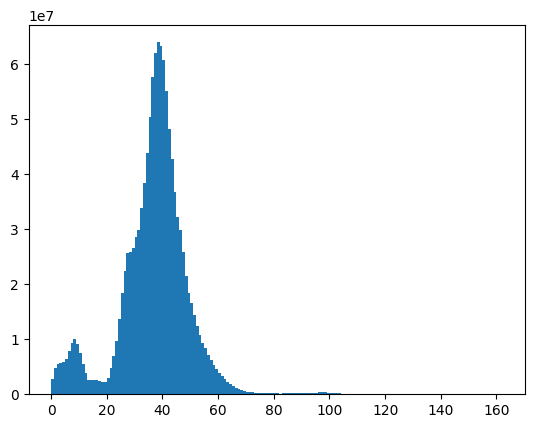

In [10]:
dist_values = distance_values(monomer_dists)
plt.hist(dist_values, bins=int(max(dist_values)))

In [11]:
# plt.matshow(monomer_dists)

In [12]:
phylogeny = clustering_to_phylogeny(
    dist_matrix=monomer_dists,
    items_as_seq_features=monomers_as_features,
    seq_references=references
).phylogeny

In [13]:
phyloXml = Phyloxml(phylogenies=[phylogeny], attributes=None)
PhyloXMLIO.write(phyloXml, f"{data_path}/monomer_phylogeny.xml")

1

In [14]:
hor_tree = phylogeny_to_hor_tree(phylogeny)

/Users/miguel/git/CENdetectHOR_lib/env/lib/python3.9/site-packages/Bio/Phylo/PhyloXML.py:985: PhyloXMLWarning: String monomer_clade_seq doesn't match the given regexp
  _check_str(ref, self.re_ref.match)


In [15]:
inversion_loops = find_inversion_loops(seq_features=monomers_as_features)
[str(loop_inSeq) for loop_inSeq in inversion_loops]

/Users/miguel/git/CENdetectHOR_lib/env/lib/python3.9/site-packages/Bio/SeqFeature.py:231: BiopythonDeprecationWarning: Please use .location.strand rather than .strand
  warnings.warn(


[]

In [16]:
phyloXml = Phyloxml(phylogenies=[hor_tree.as_phyloxml], attributes=None)
PhyloXMLIO.write(phyloXml, f"{data_path}/HORs.xml")

1

In [17]:
phyloXml = Phyloxml(phylogenies=[phylogeny, hor_tree.as_phyloxml], attributes=None)
PhyloXMLIO.write(phyloXml, f"{data_path}/monomer_phylogeny_and_HORs.xml")

2

Subtree: []


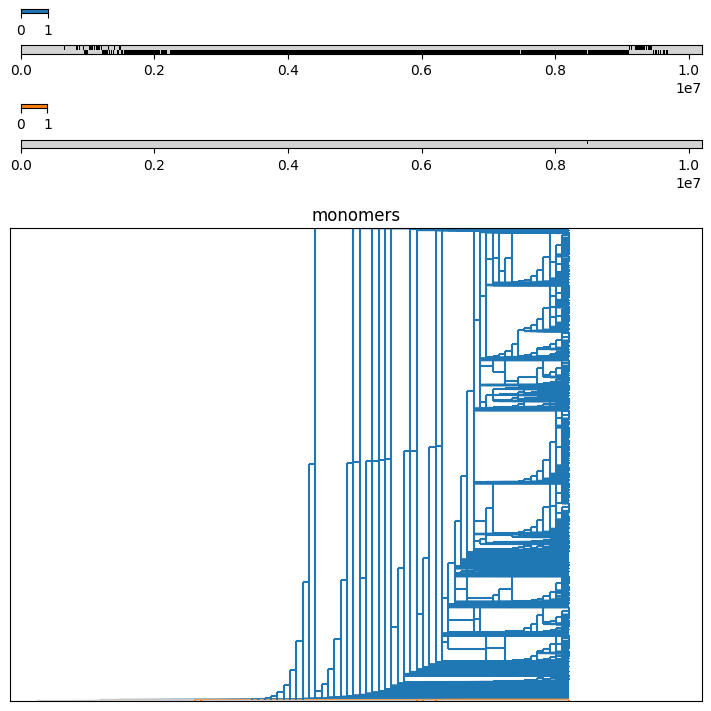

Subtree: [1]


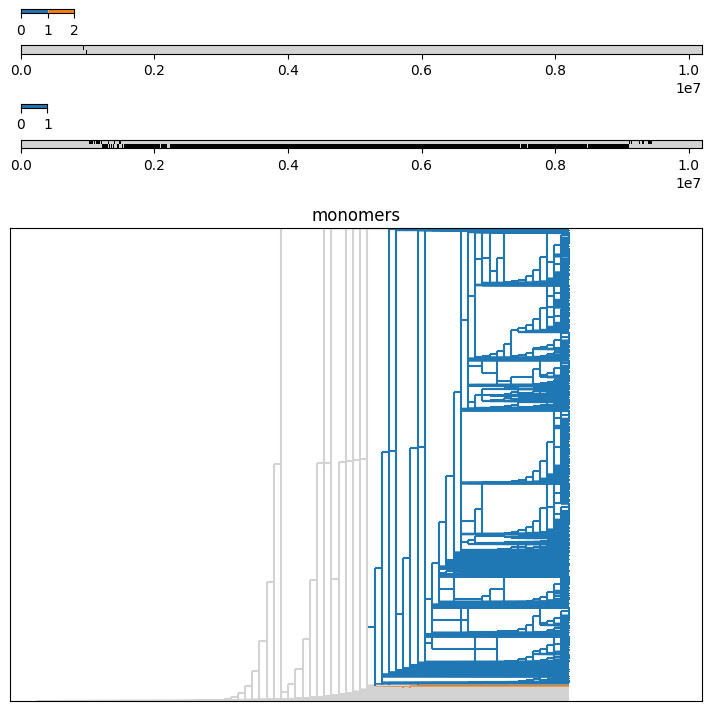

Subtree: [1, 2]


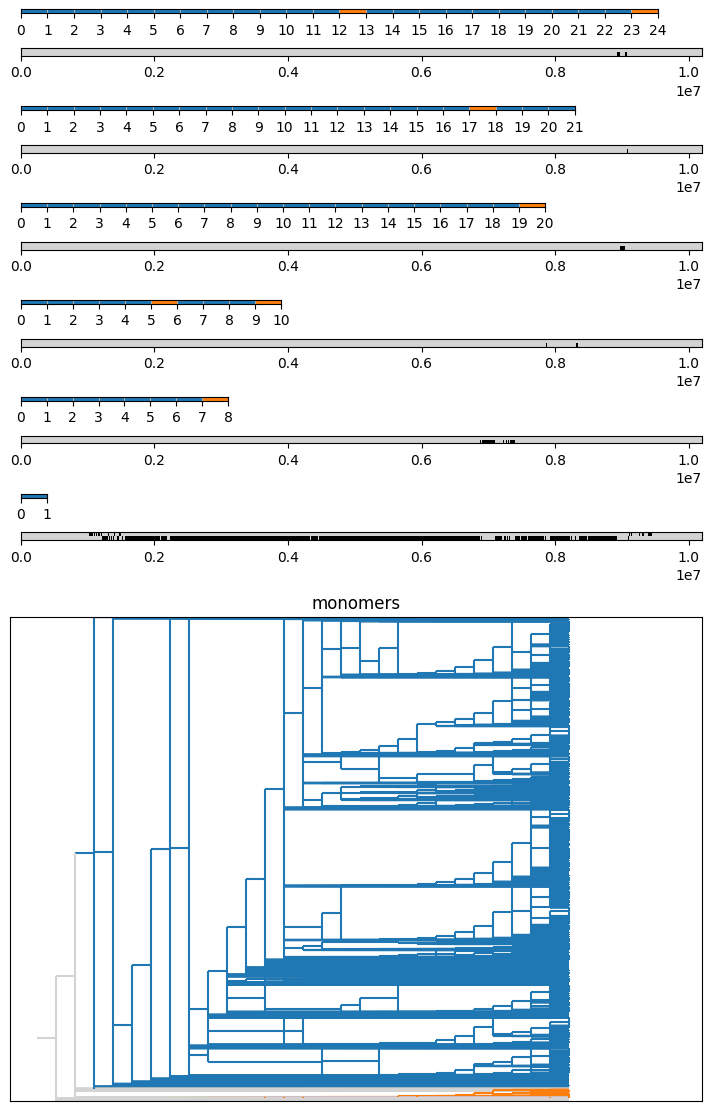

Subtree: [1, 2, 1]


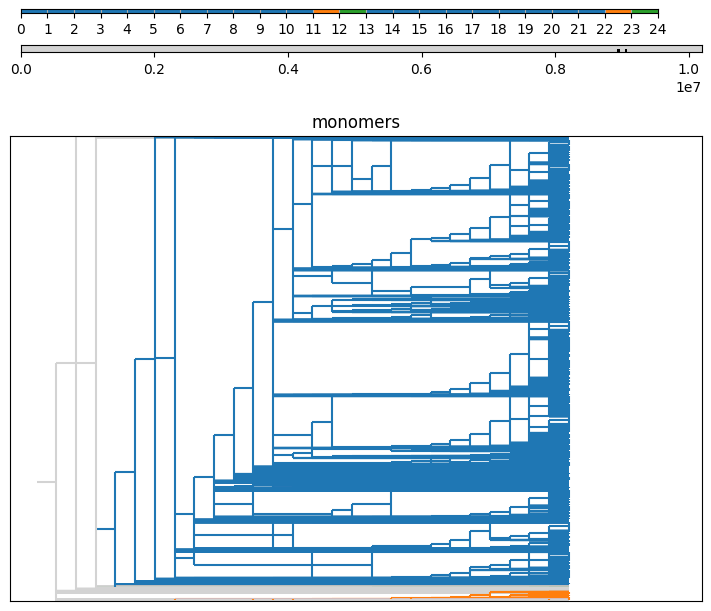

Subtree: [1, 2, 1, 1]


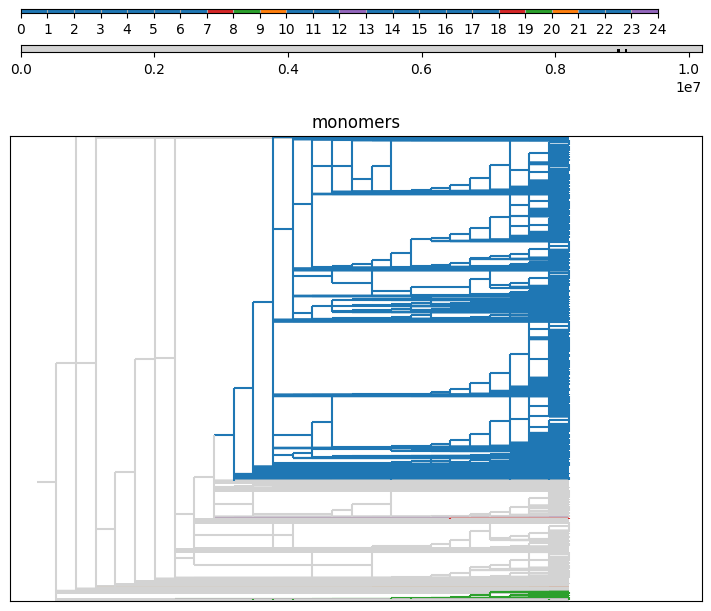

Subtree: [1, 2, 1, 1, 1]


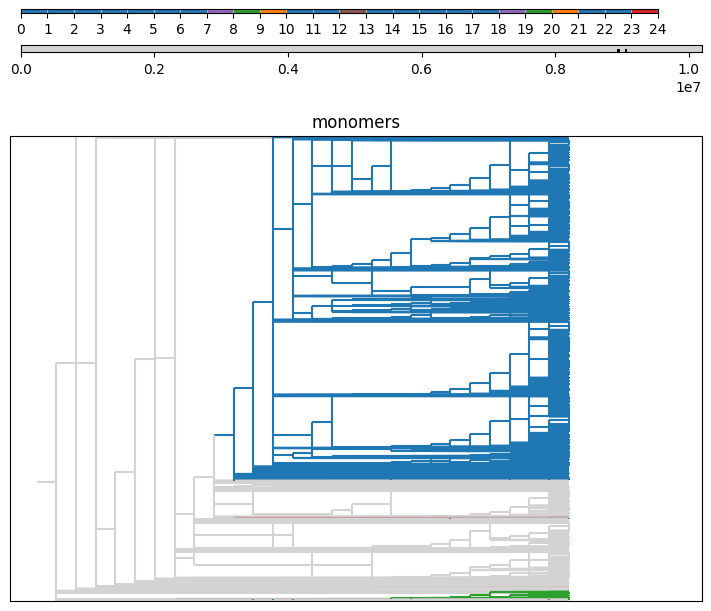

Subtree: [1, 2, 1, 1, 1, 1]


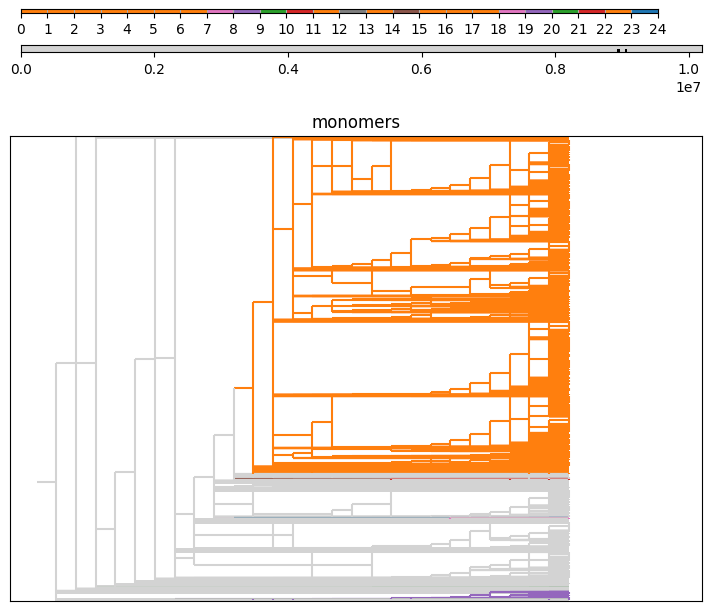

Subtree: [1, 2, 1, 1, 1, 1, 1]


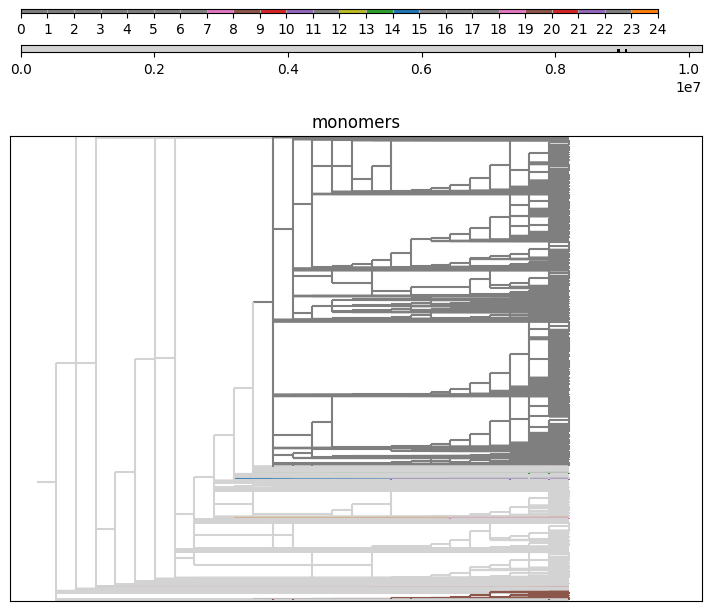

Subtree: [1, 2, 1, 1, 1, 1, 1, 1]


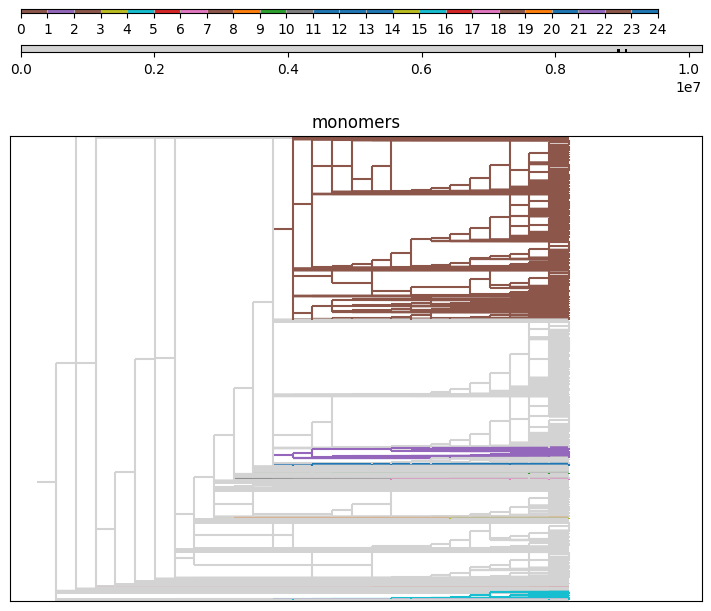

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1]


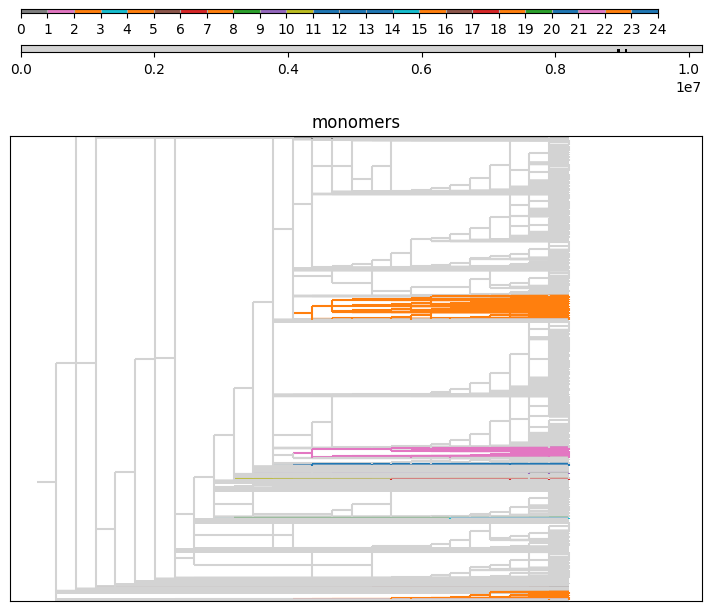

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1]


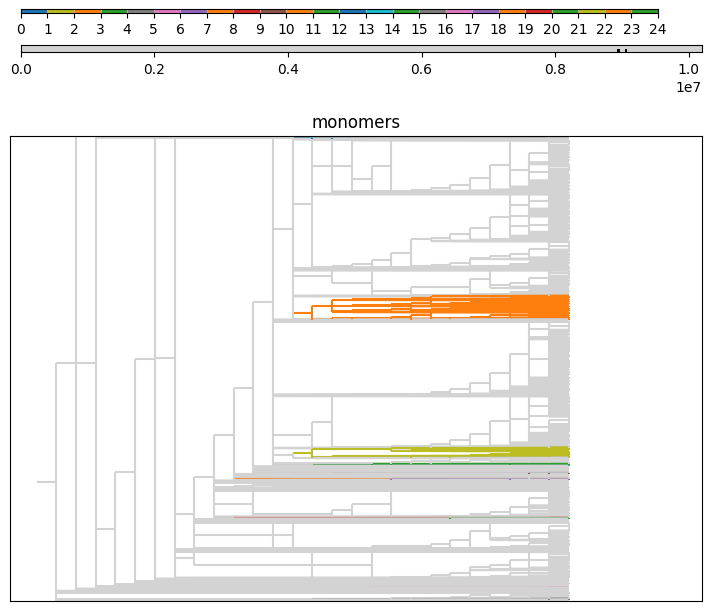

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


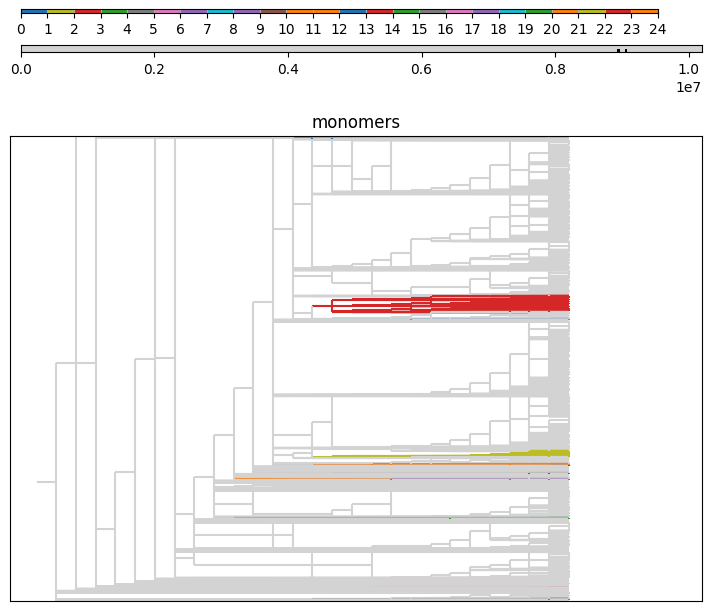

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


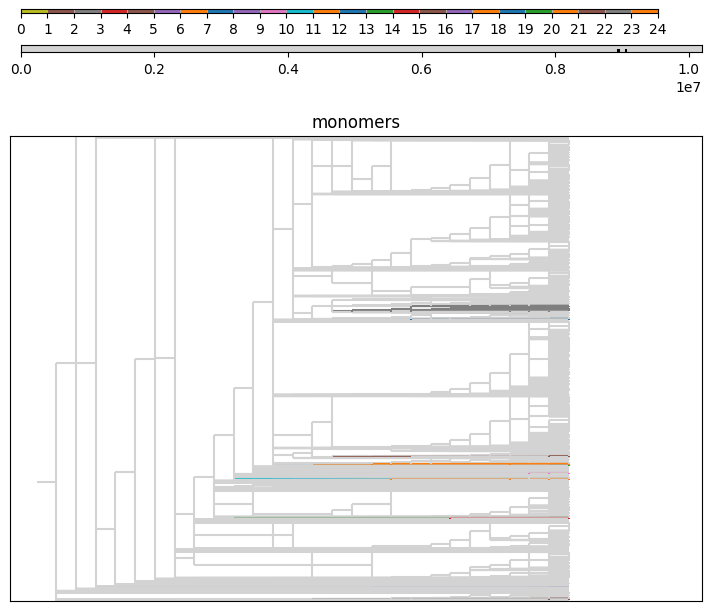

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


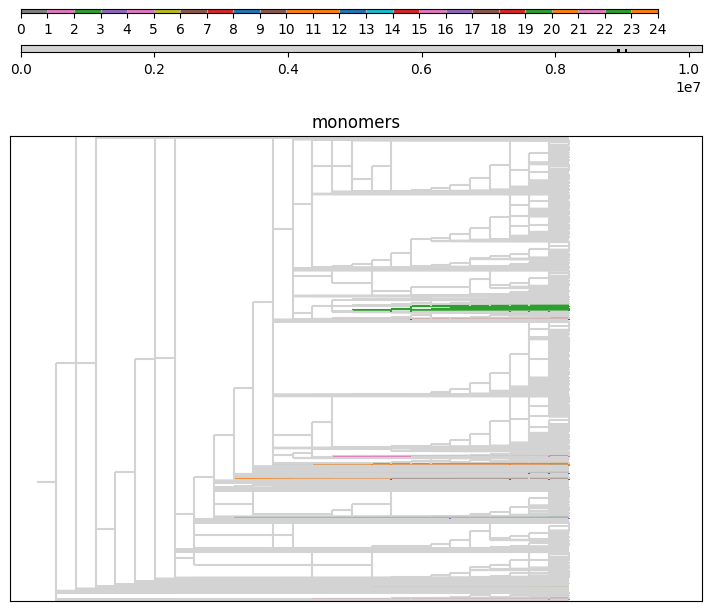

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


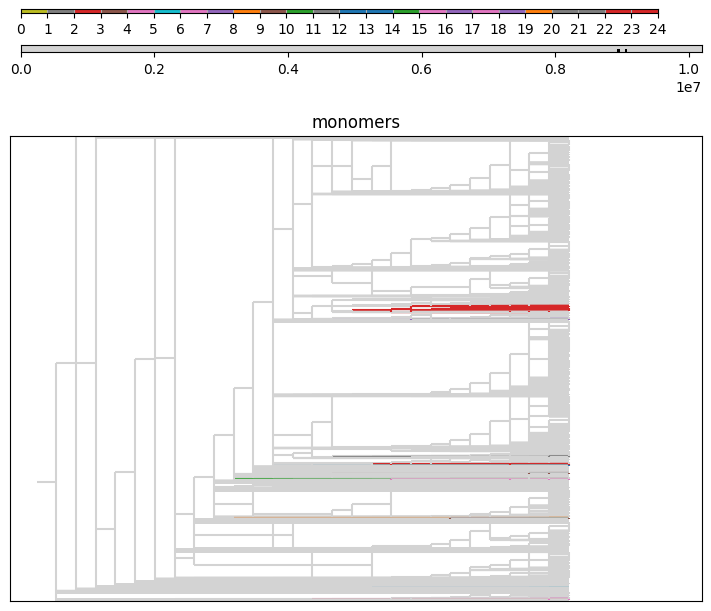

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


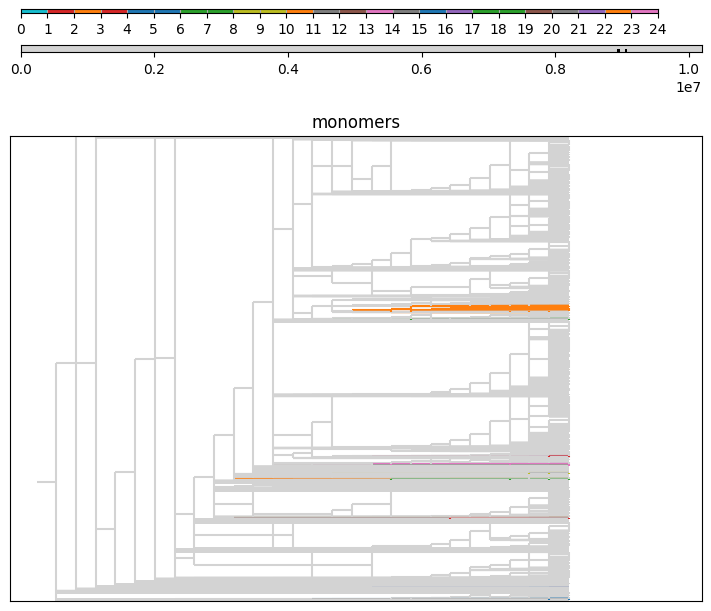

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


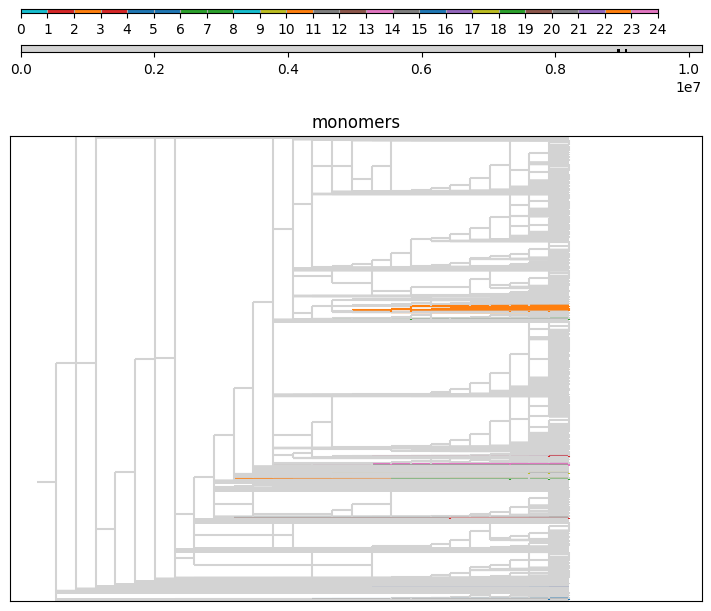

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


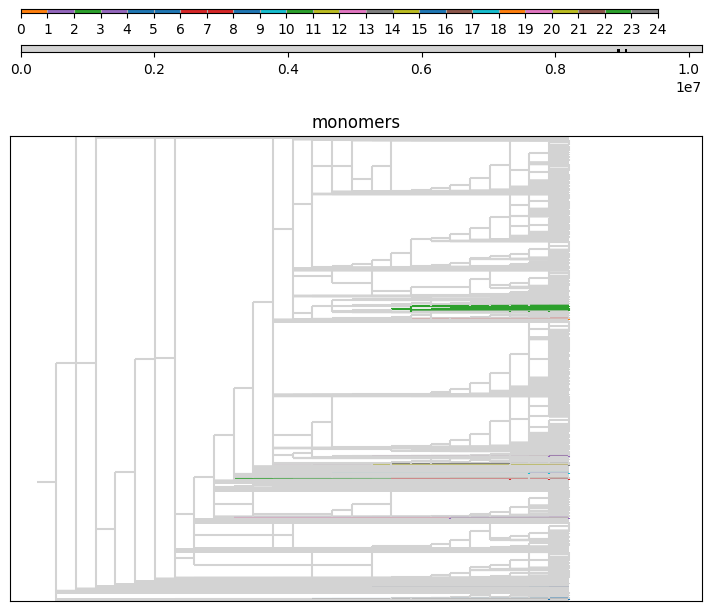

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


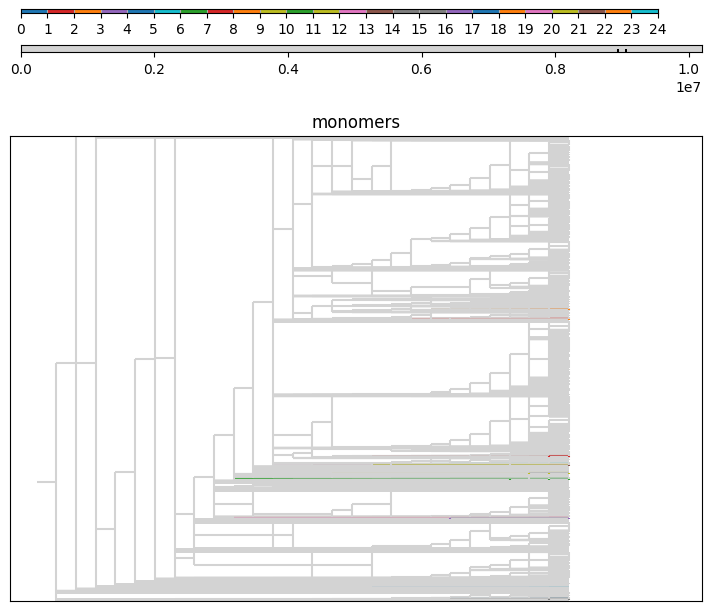

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


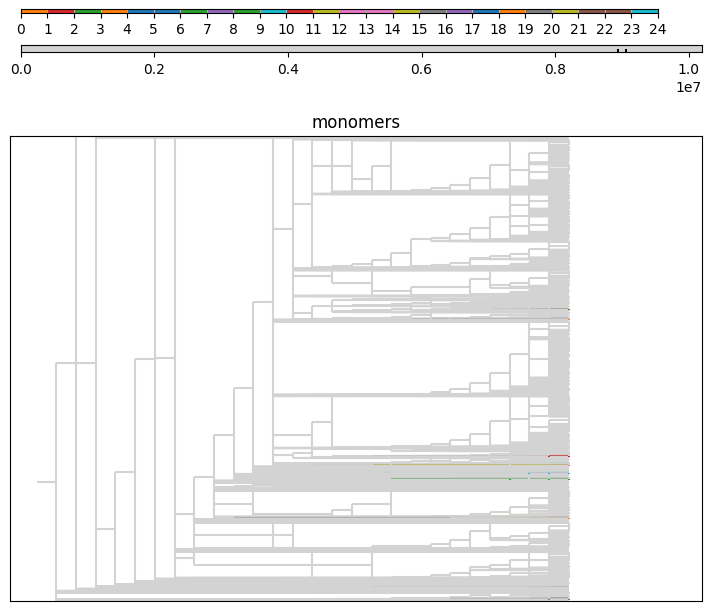

Subtree: [1, 2, 3]


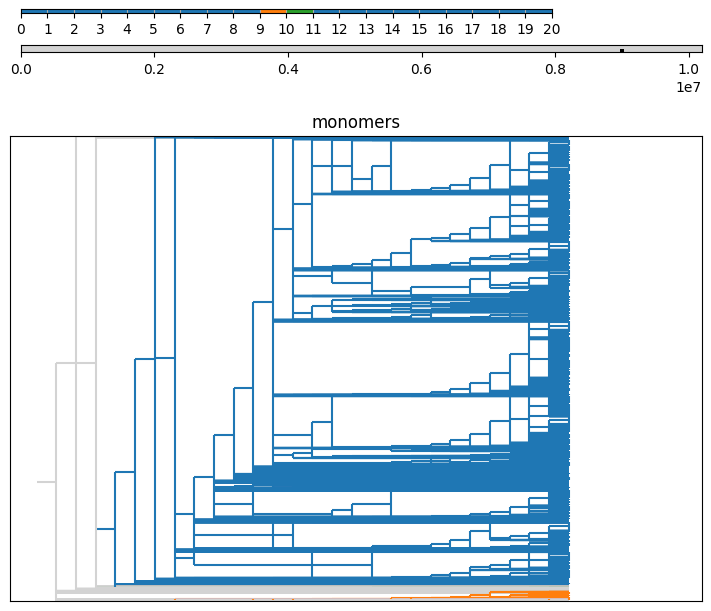

Subtree: [1, 2, 3, 1]


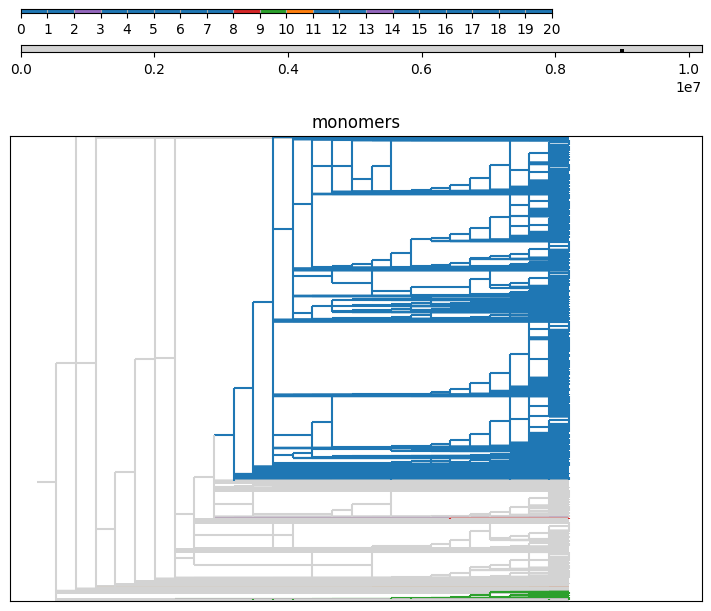

Subtree: [1, 2, 3, 1, 1]


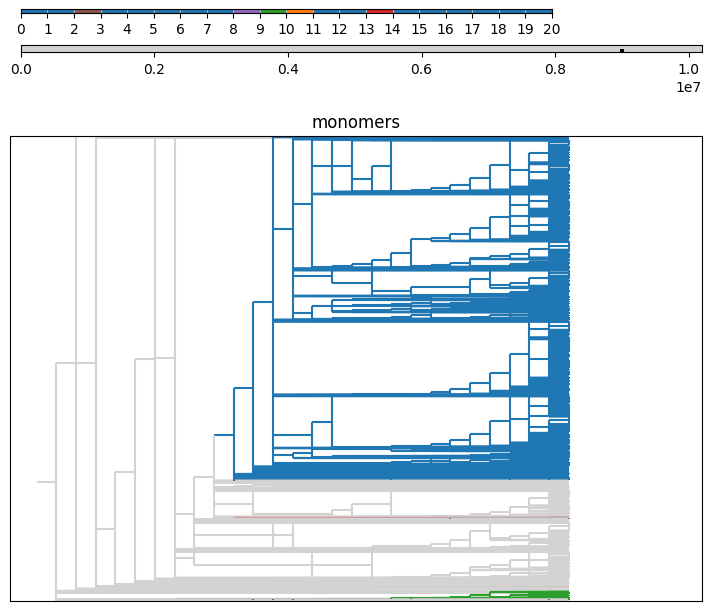

Subtree: [1, 2, 3, 1, 1, 1]


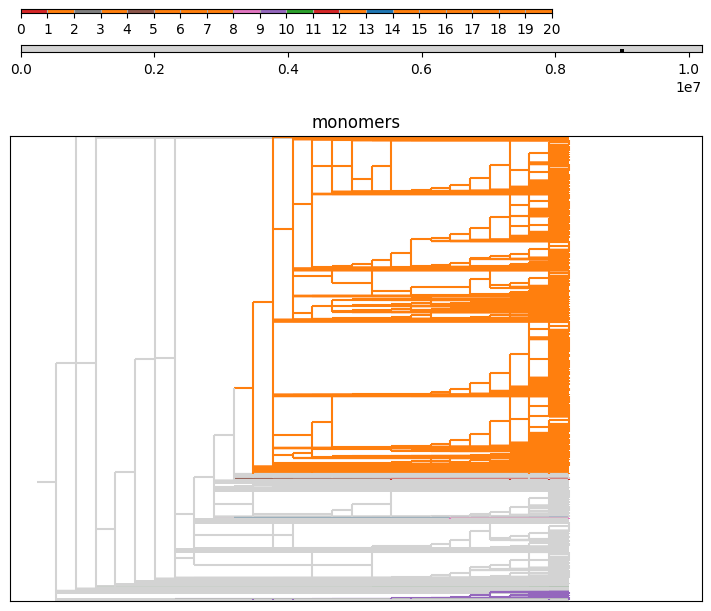

Subtree: [1, 2, 3, 1, 1, 1, 1]


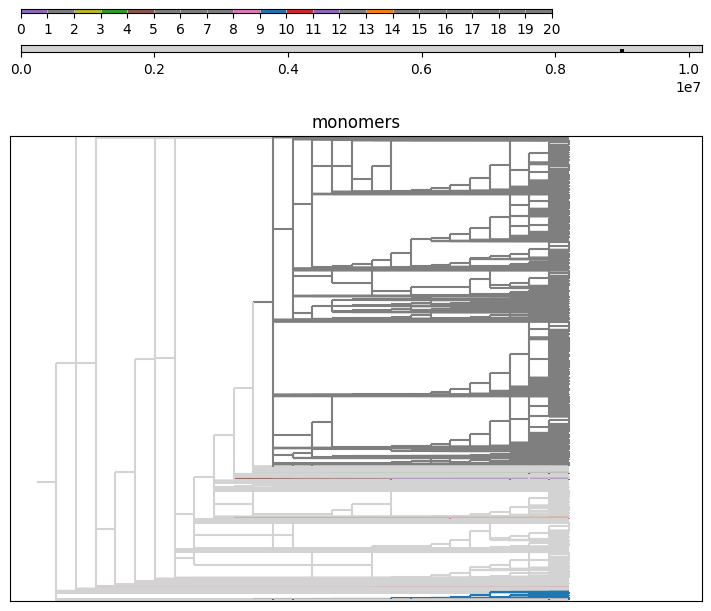

Subtree: [1, 2, 3, 1, 1, 1, 1, 1]


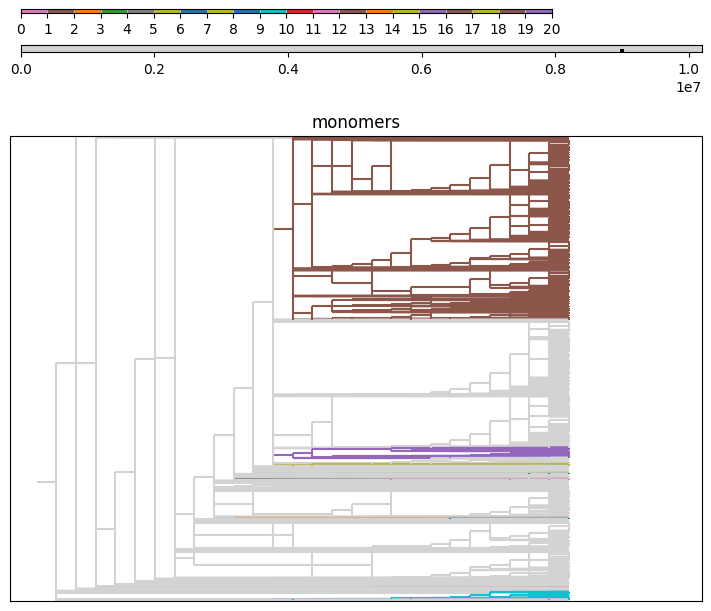

Subtree: [1, 2, 3, 1, 1, 1, 1, 1, 1]


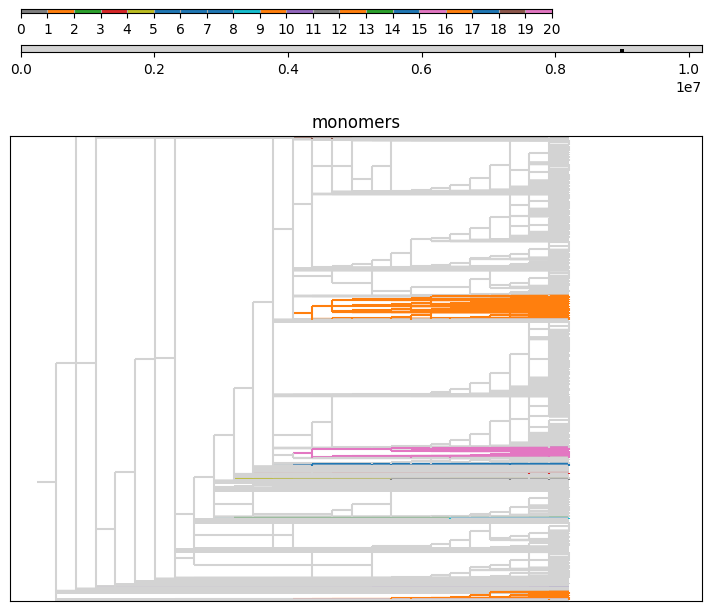

Subtree: [1, 2, 3, 1, 1, 1, 1, 1, 1, 1]


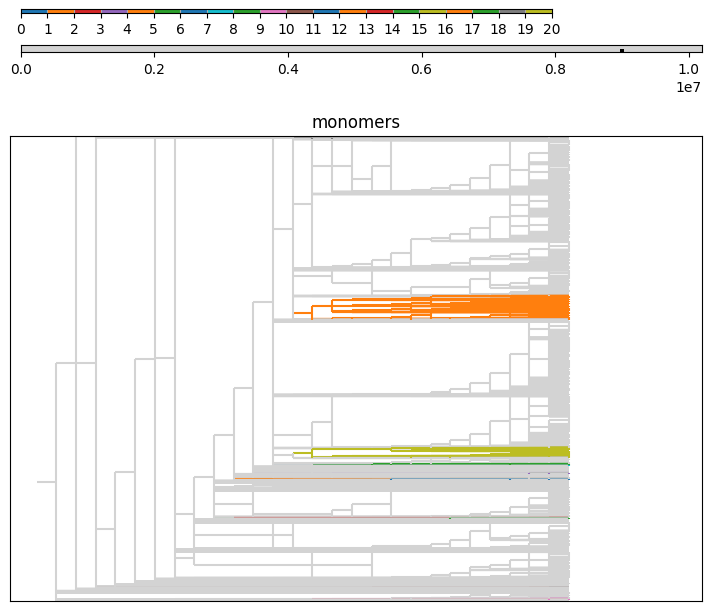

Subtree: [1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1]


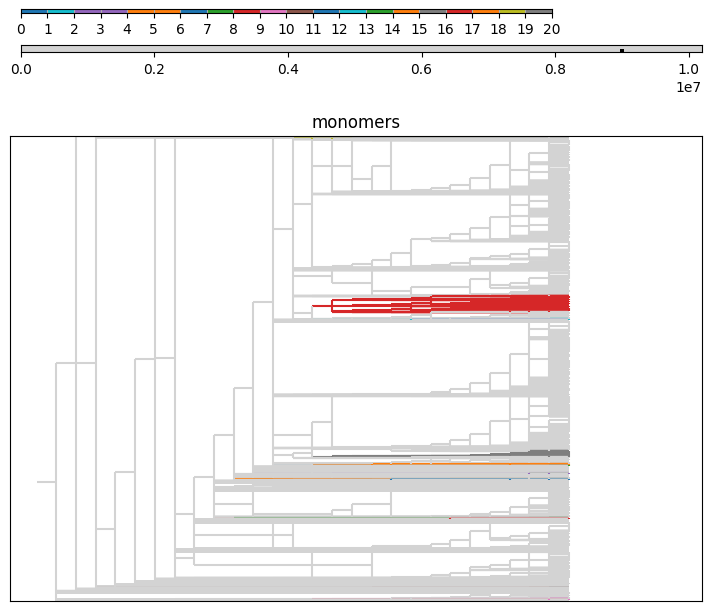

Subtree: [1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]


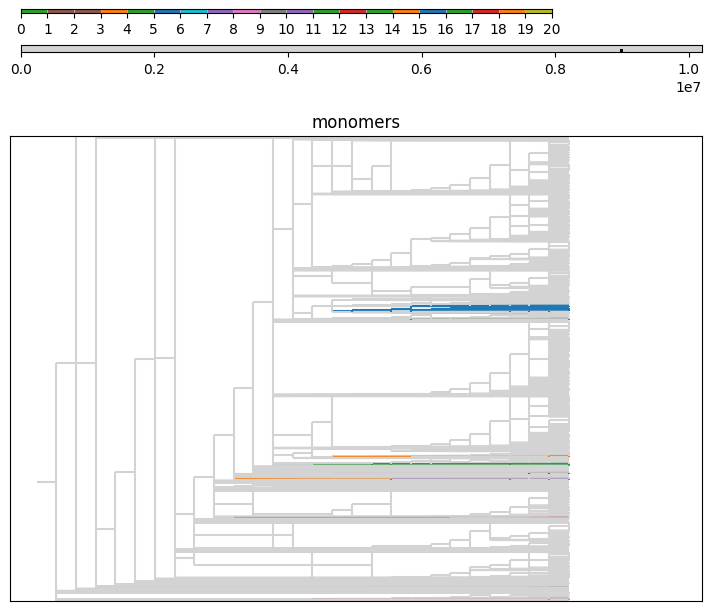

Subtree: [1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


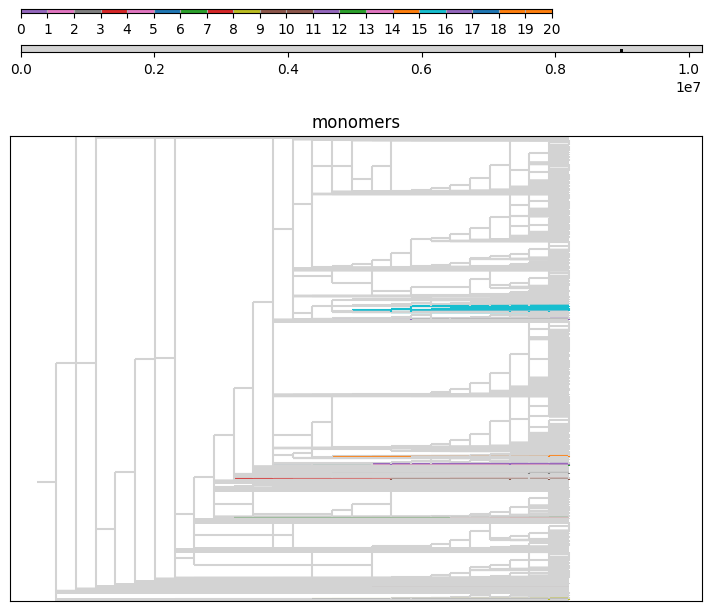

Subtree: [1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


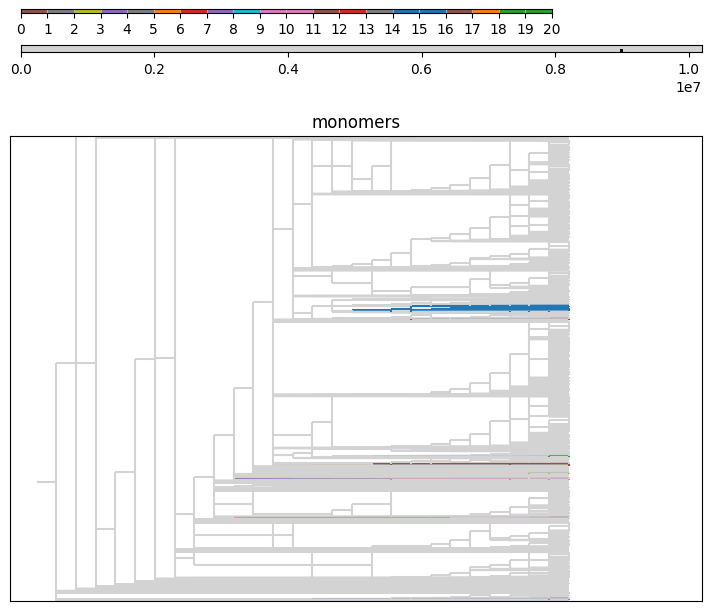

Subtree: [1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


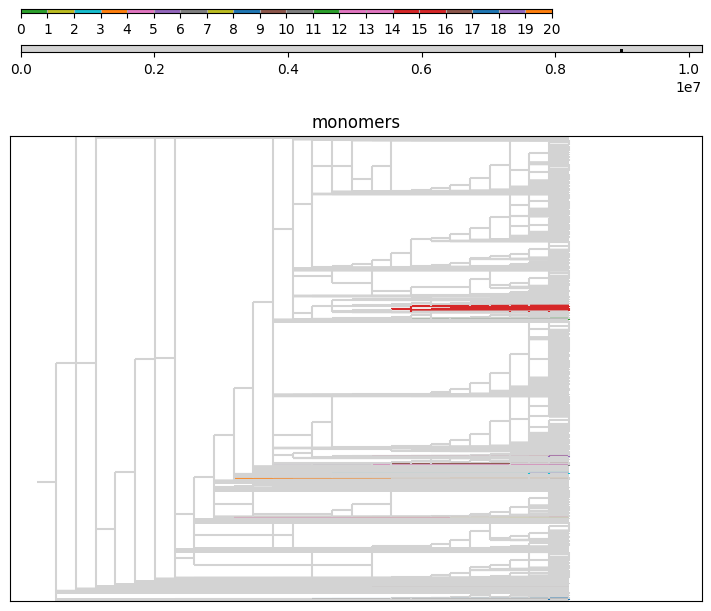

Subtree: [1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


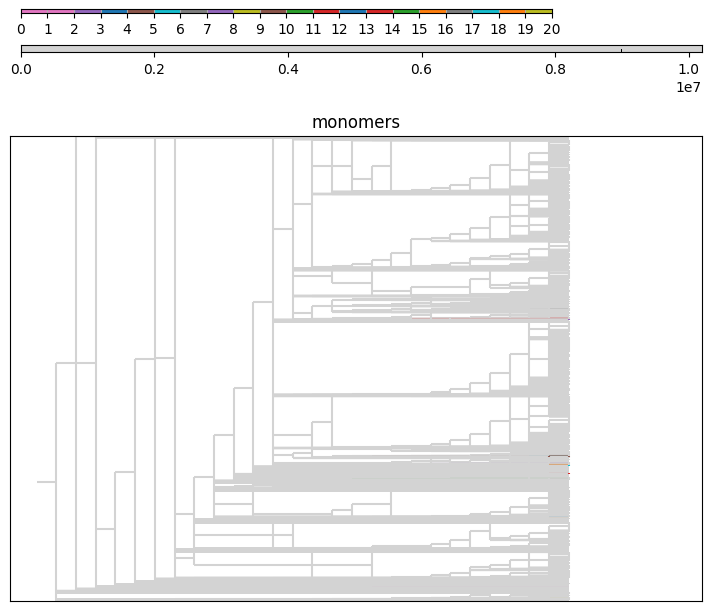

Subtree: [1, 2, 4]


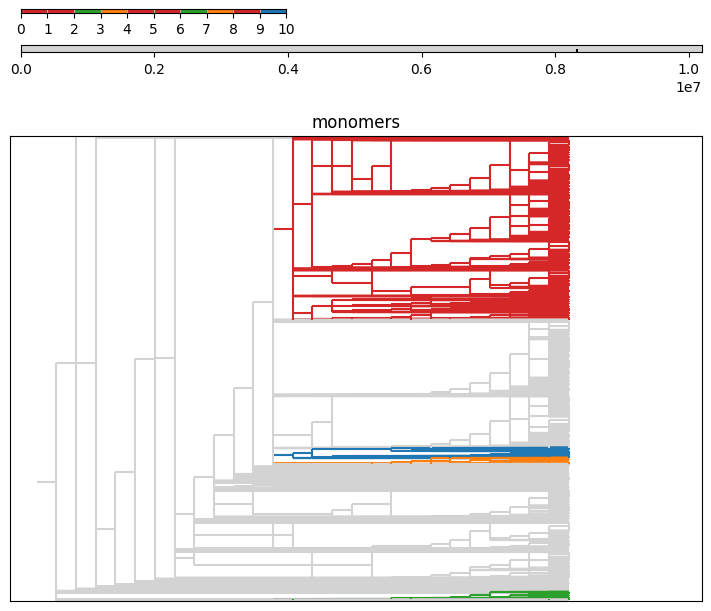

Subtree: [1, 2, 4, 1]


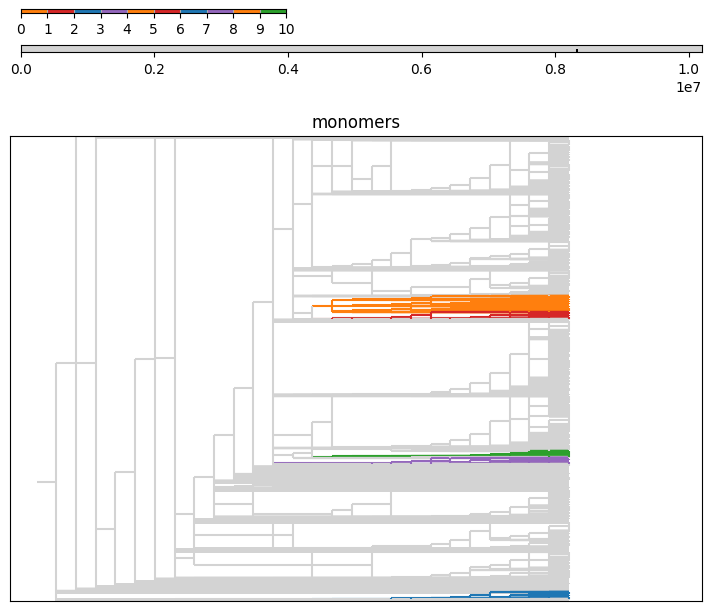

Subtree: [1, 2, 4, 1, 1]


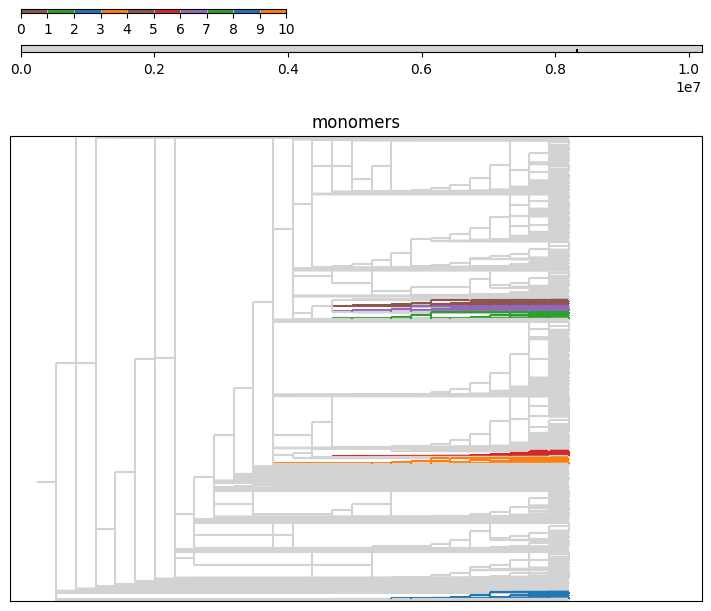

Subtree: [1, 2, 4, 1, 1, 1]


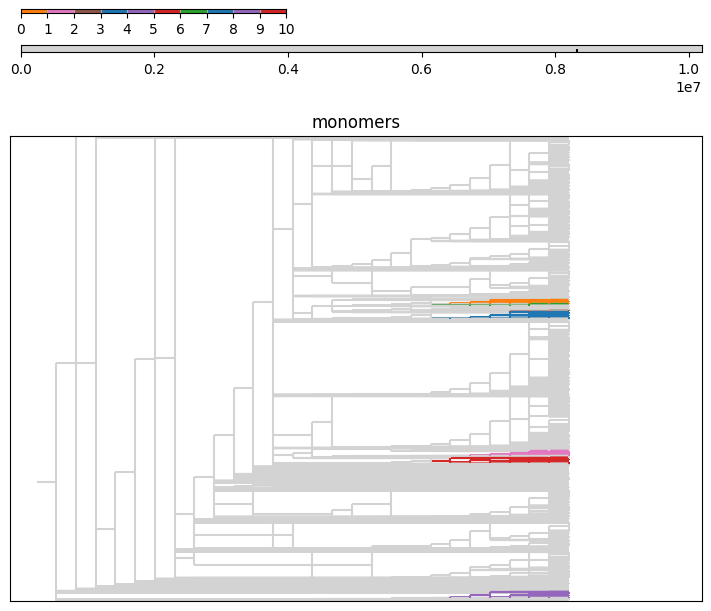

Subtree: [1, 2, 4, 1, 1, 1, 1]


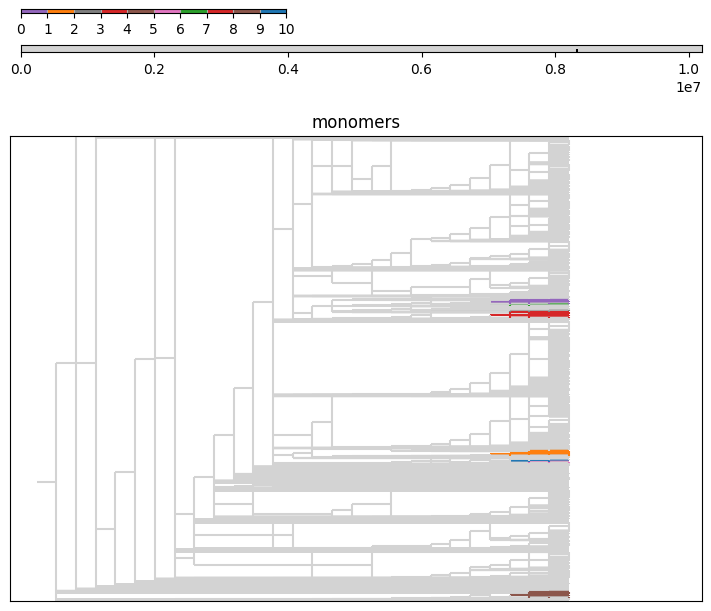

Subtree: [1, 2, 4, 1, 1, 1, 1, 1]


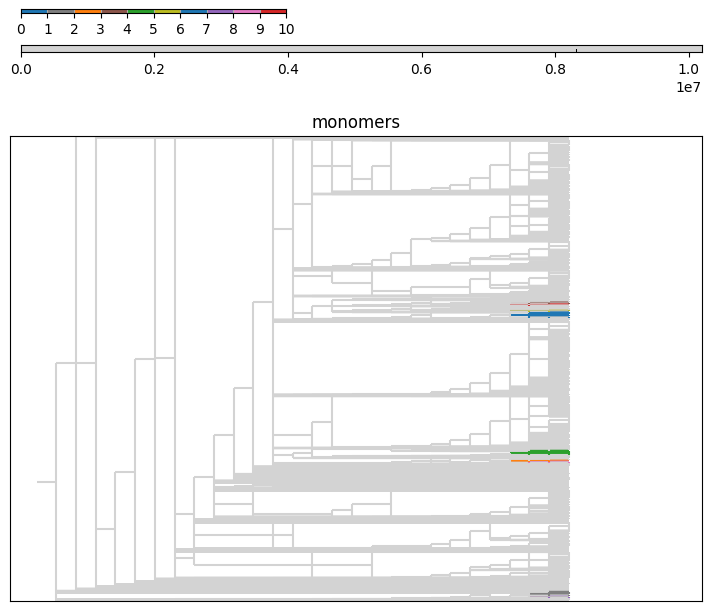

Subtree: [1, 2, 4, 1, 1, 1, 1, 1, 1]


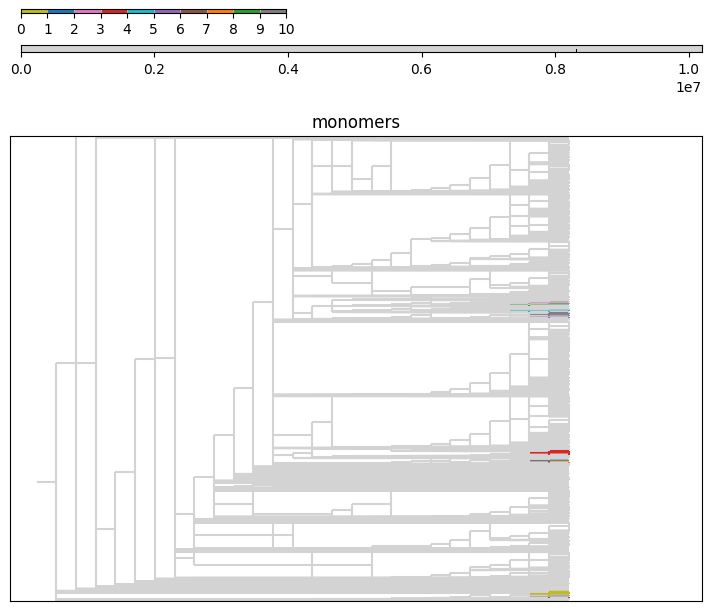

Subtree: [1, 2, 5]


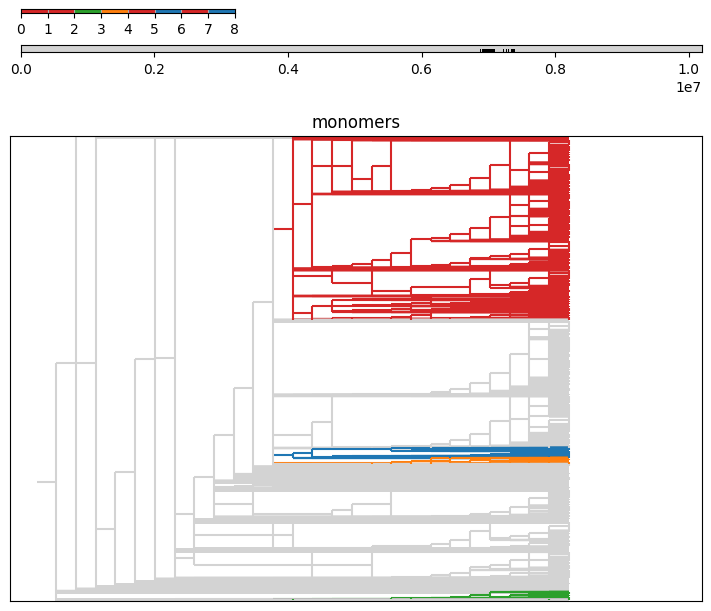

Subtree: [1, 2, 5, 1]


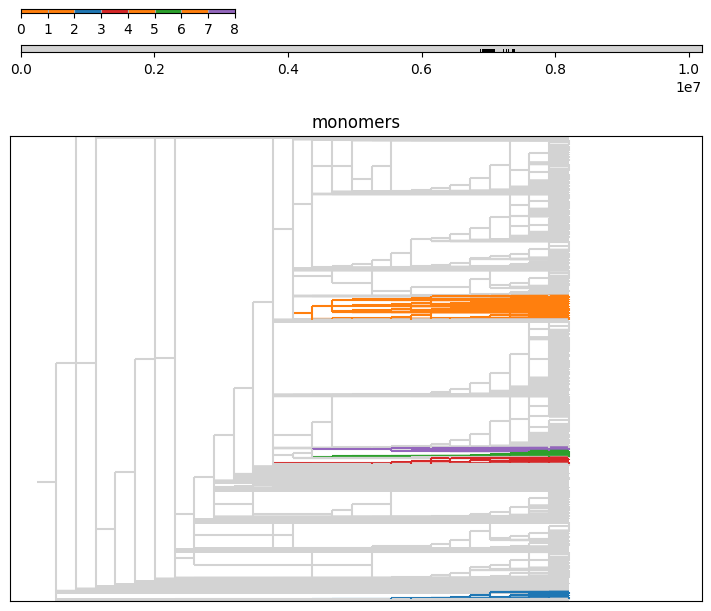

Subtree: [1, 2, 5, 1, 1]


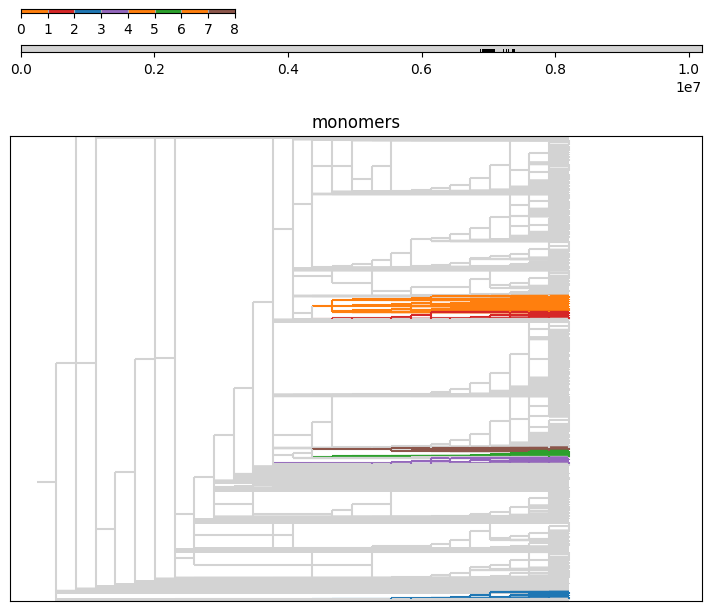

Subtree: [1, 2, 5, 1, 1, 1]


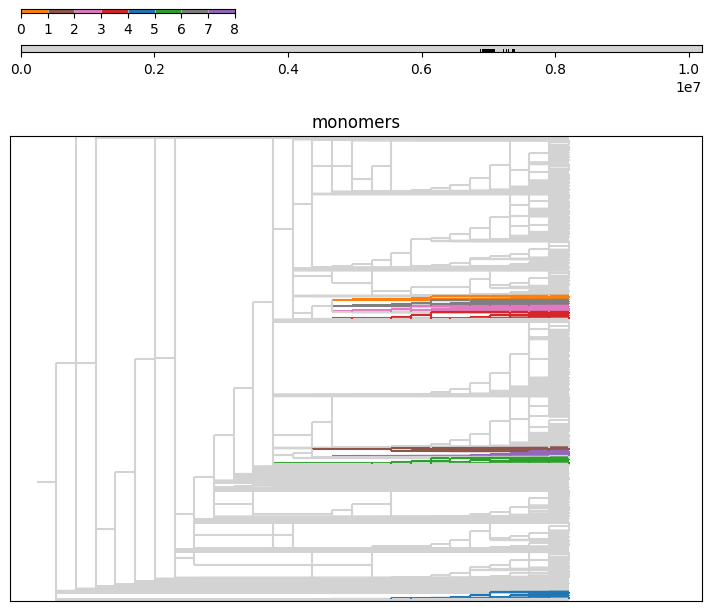

Subtree: [1, 2, 5, 1, 1, 1, 1]


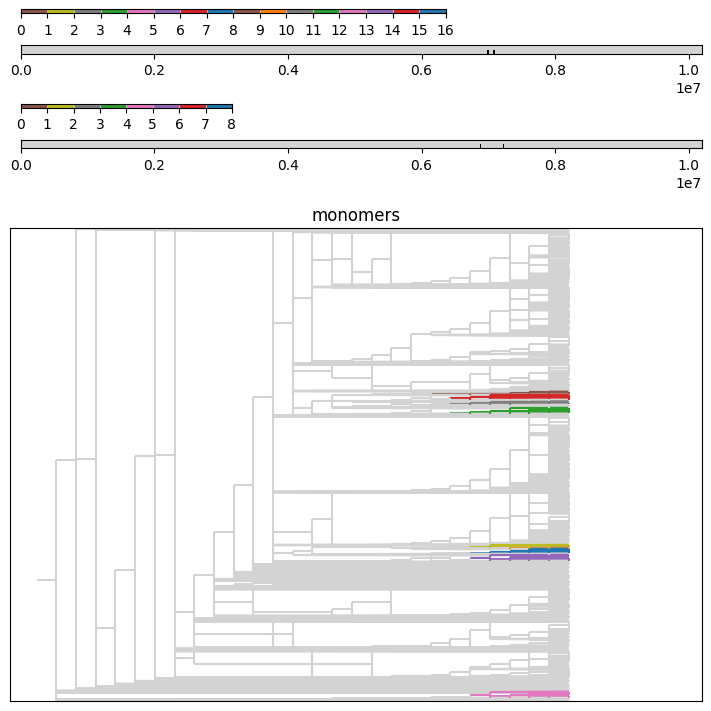

Subtree: [1, 2, 6]


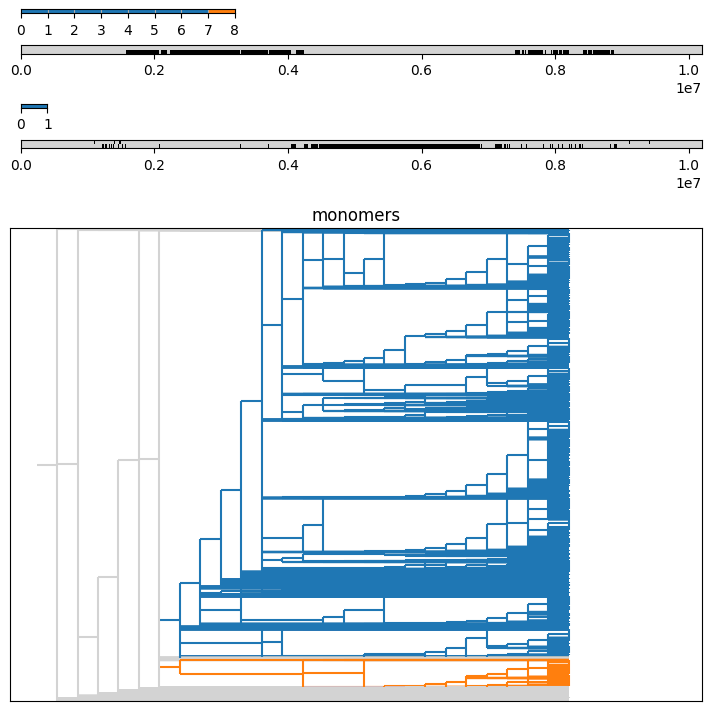

Subtree: [1, 2, 6, 1]


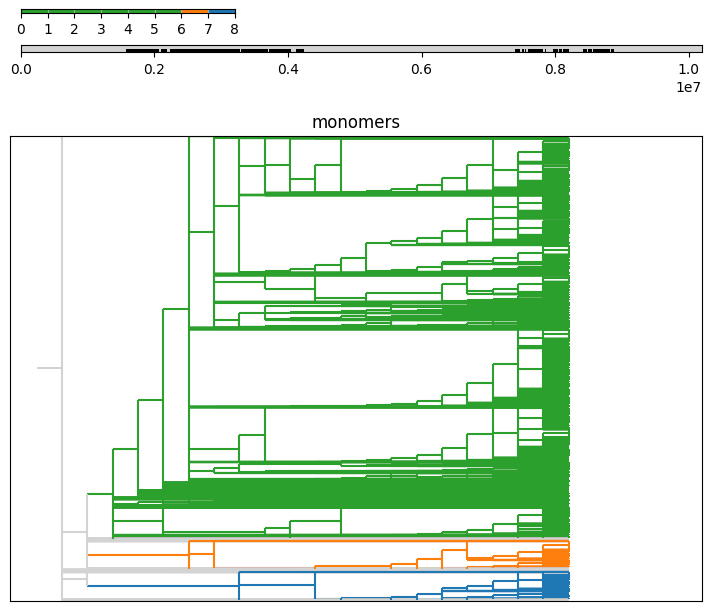

Subtree: [1, 2, 6, 1, 1]


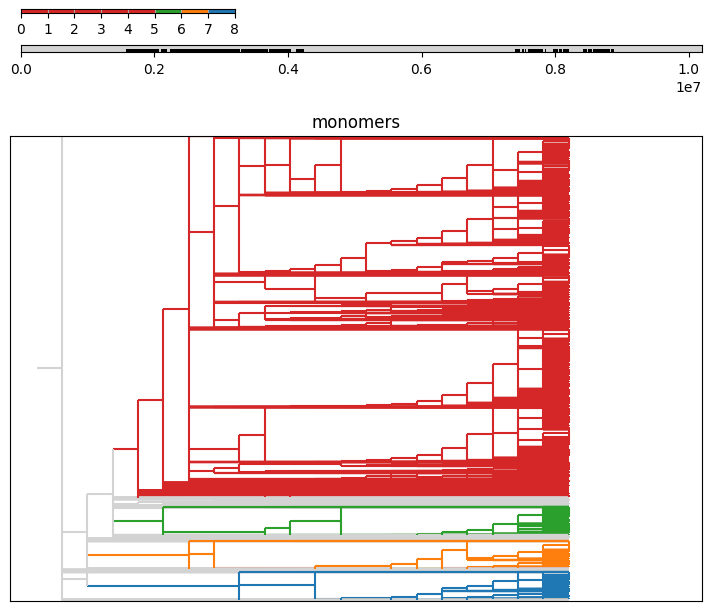

Subtree: [1, 2, 6, 1, 1, 1]


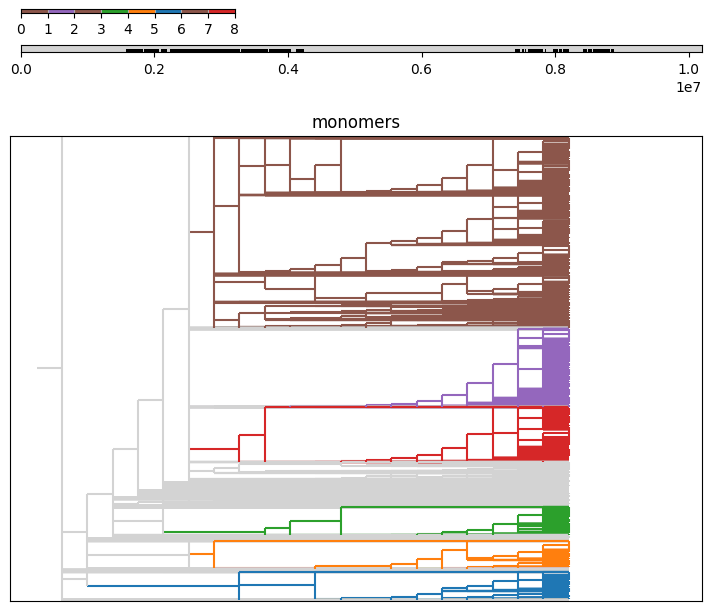

Subtree: [1, 2, 6, 1, 1, 1, 1]


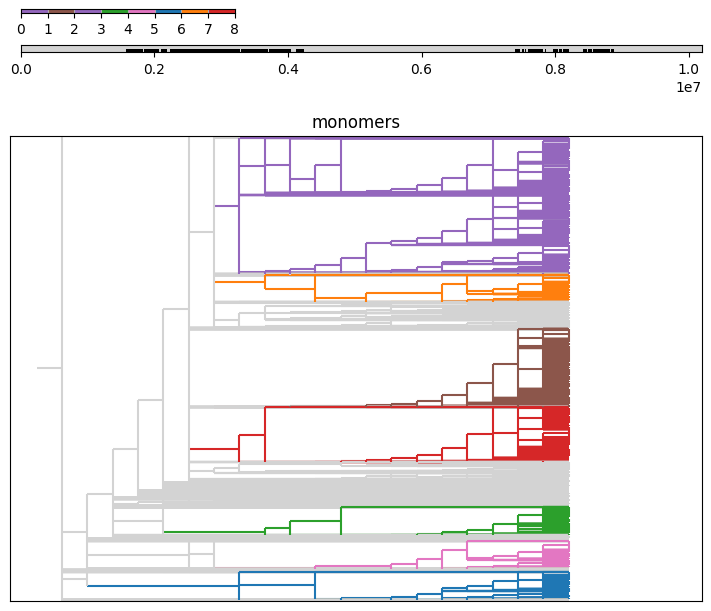

Subtree: [1, 2, 6, 1, 1, 1, 1, 1]


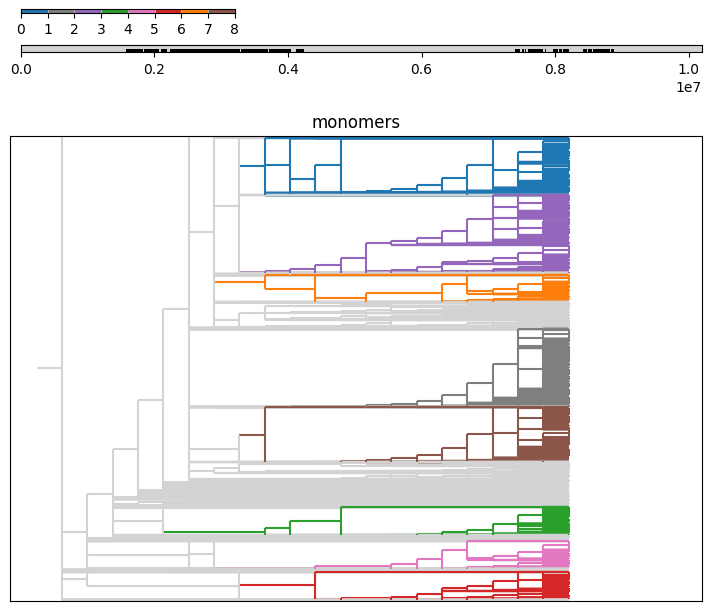

Subtree: [1, 2, 6, 1, 1, 1, 1, 1, 1]


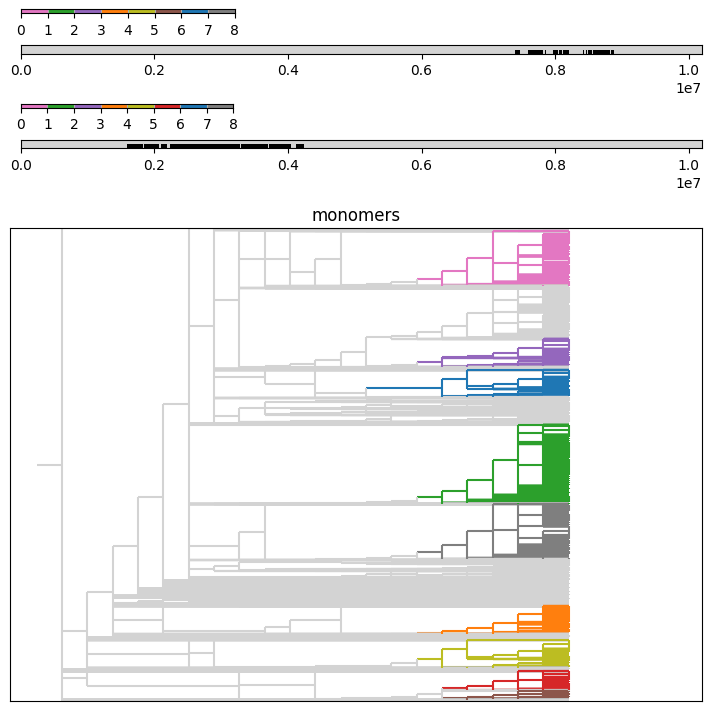

Subtree: [1, 2, 6, 1, 1, 1, 1, 1, 1, 1]


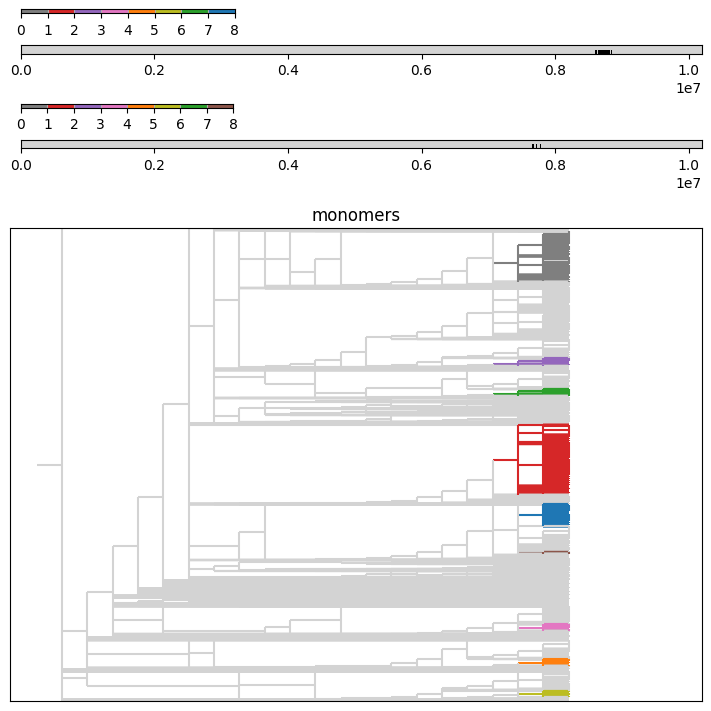

Subtree: [1, 2, 6, 1, 1, 1, 1, 1, 1, 2]


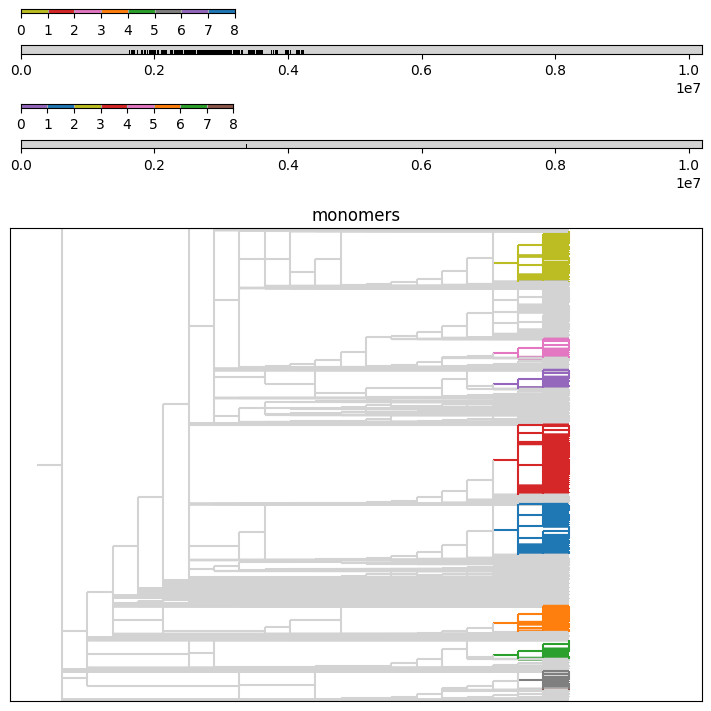

Subtree: [1, 2, 6, 1, 1, 1, 1, 1, 1, 2, 1]


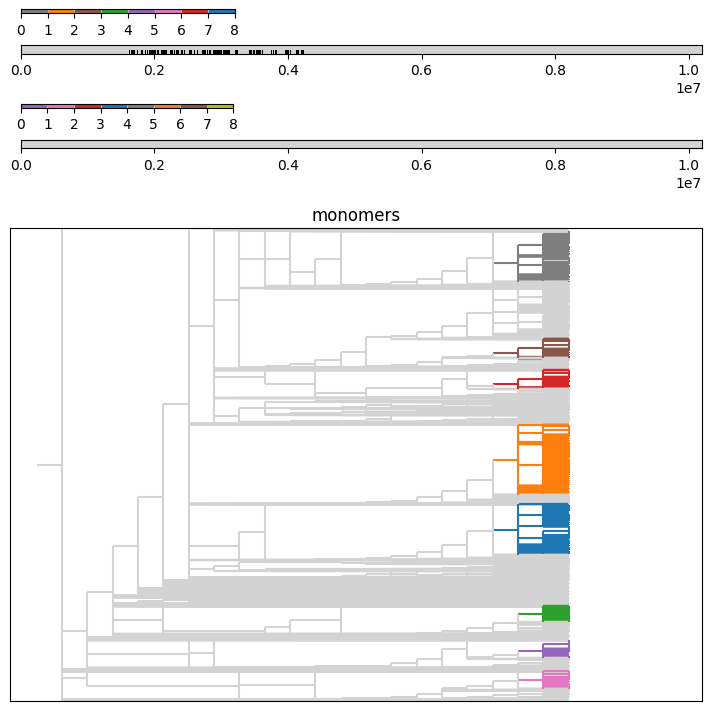

Subtree: [1, 2, 6, 1, 1, 1, 1, 1, 1, 2, 1, 1]


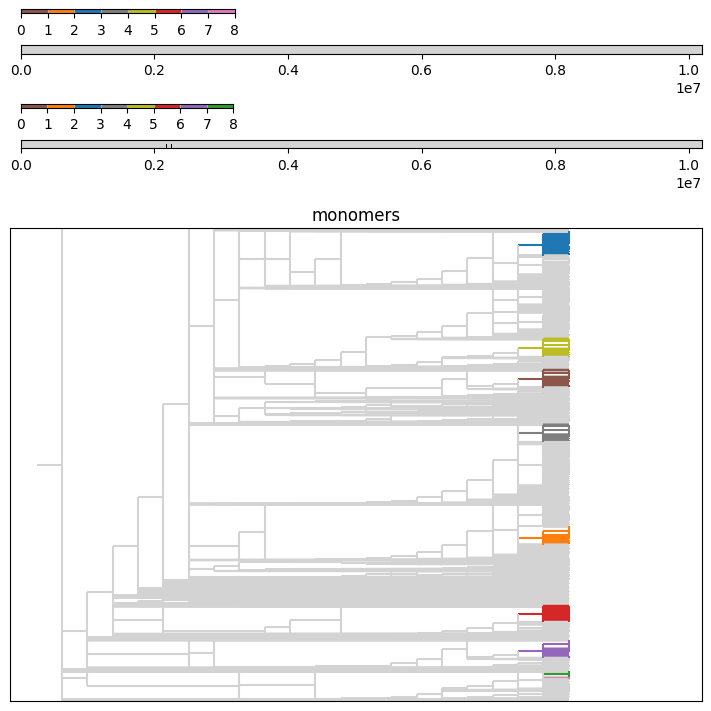

Subtree: [1, 2, 6, 2]


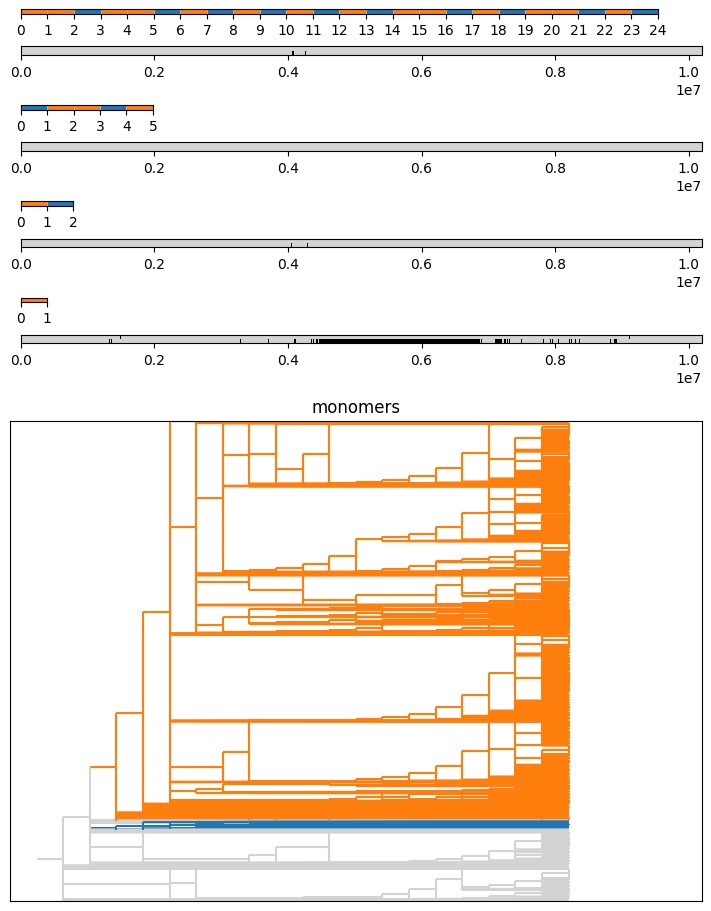

Subtree: [1, 2, 6, 2, 1]


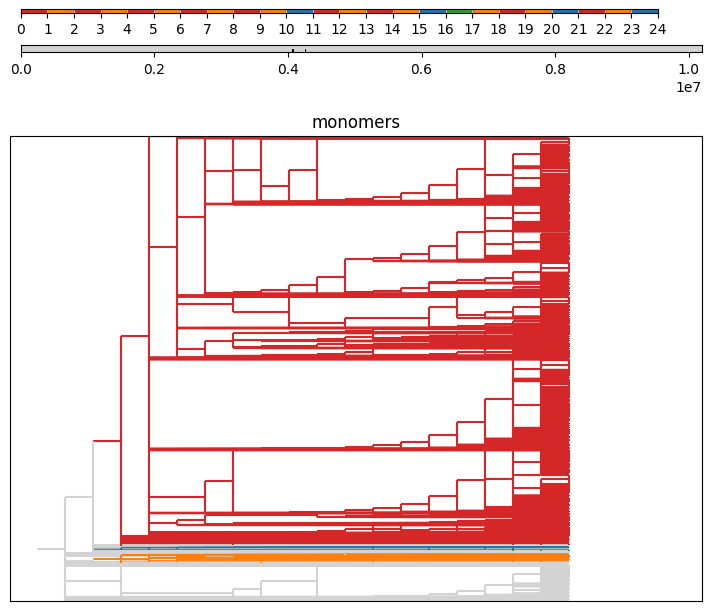

Subtree: [1, 2, 6, 2, 1, 1]


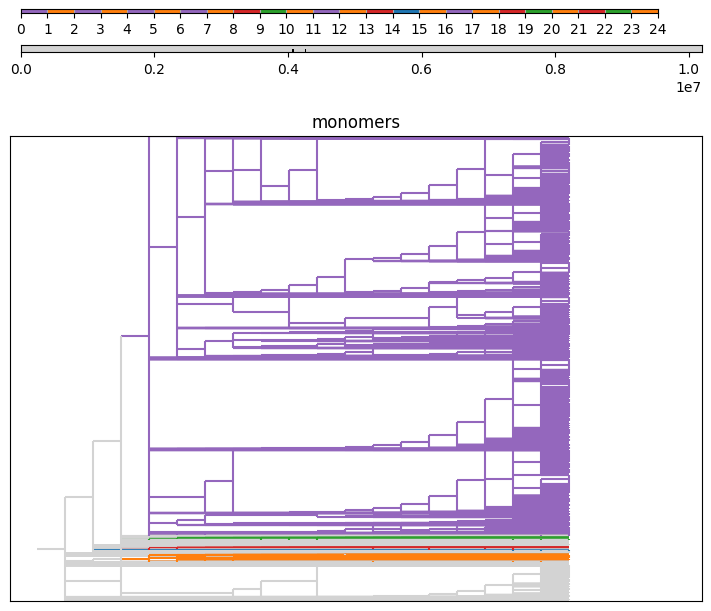

Subtree: [1, 2, 6, 2, 1, 1, 1]


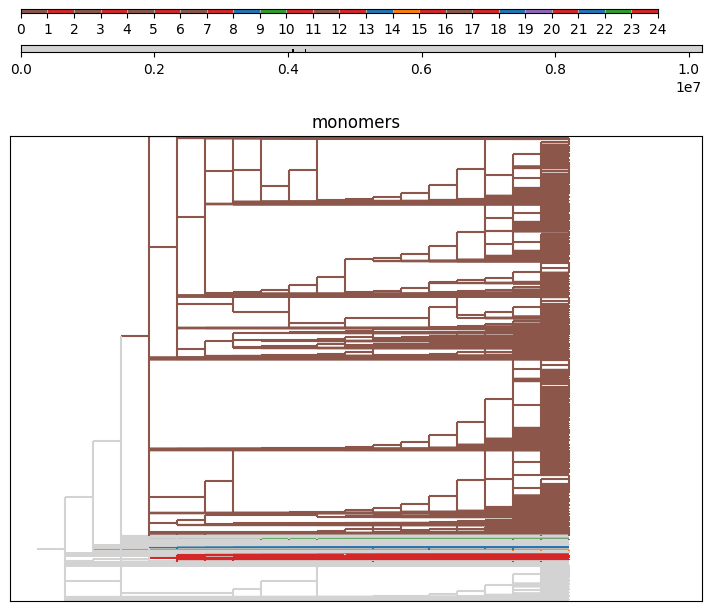

Subtree: [1, 2, 6, 2, 1, 1, 1, 1]


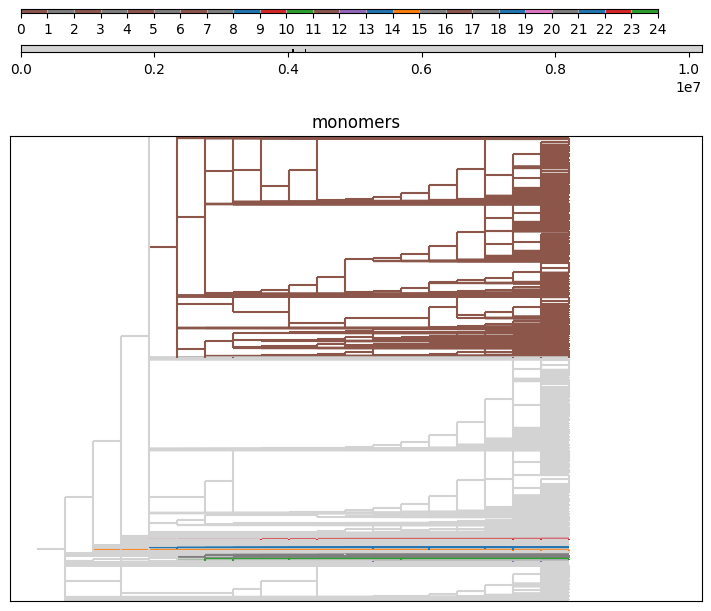

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1]


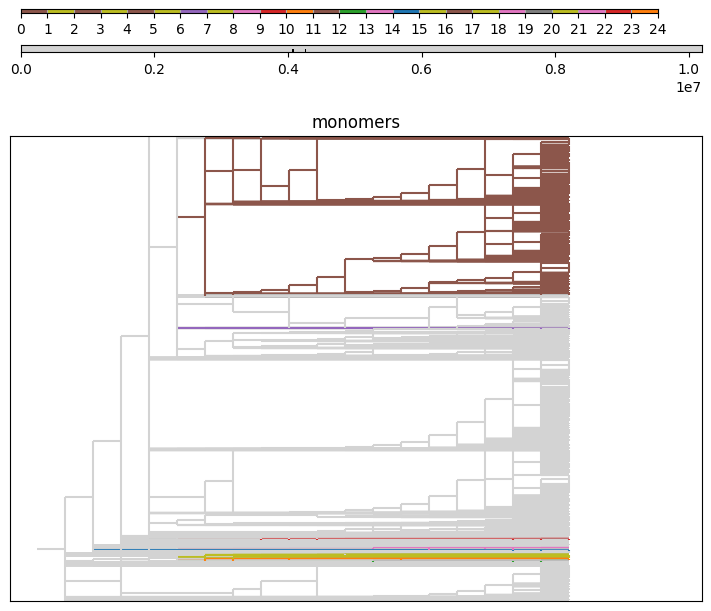

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1]


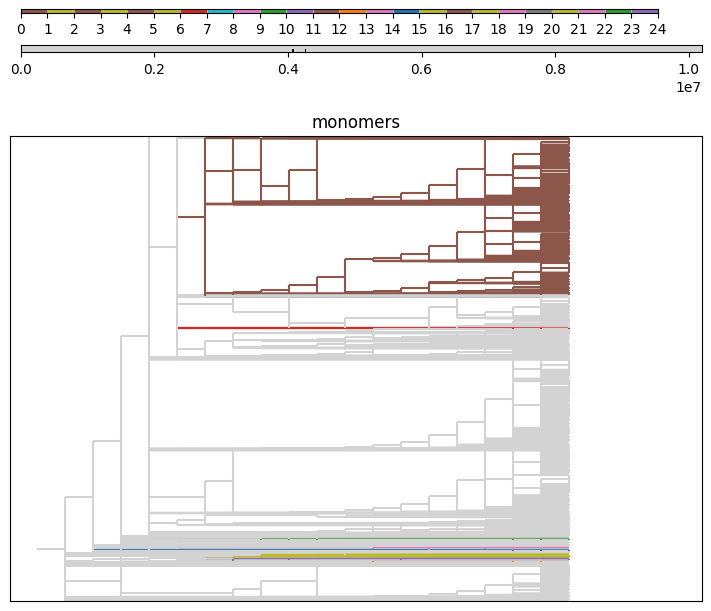

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1]


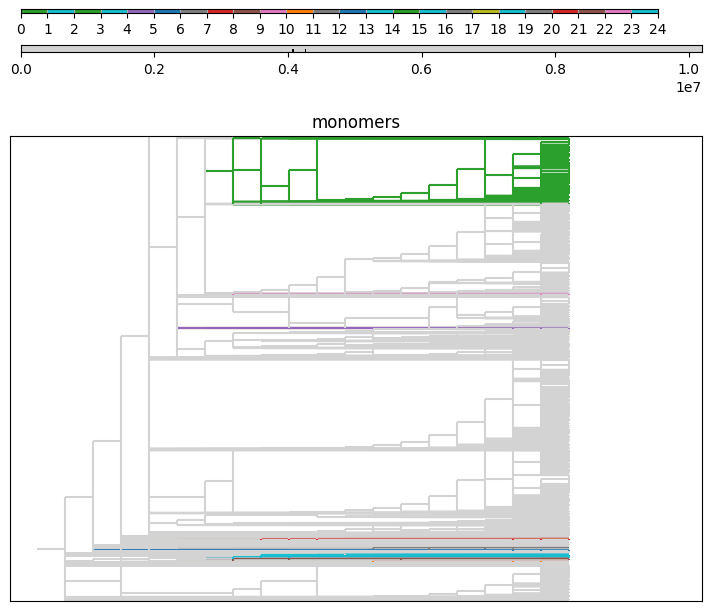

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1]


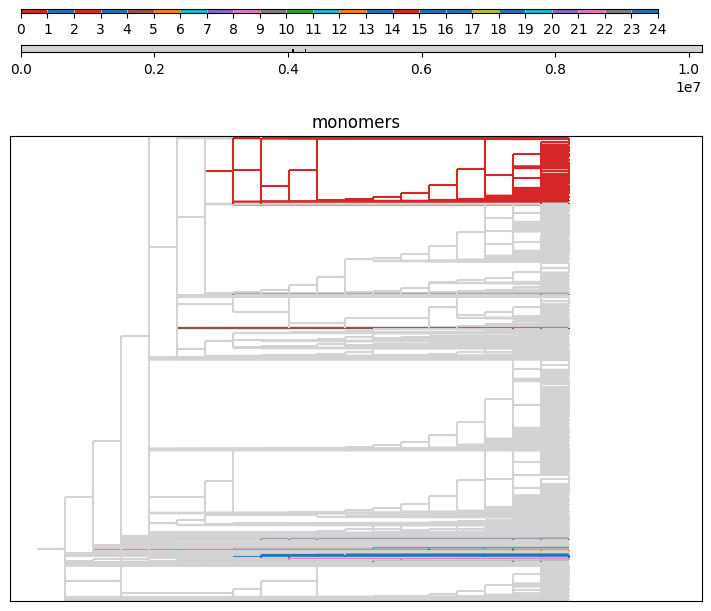

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


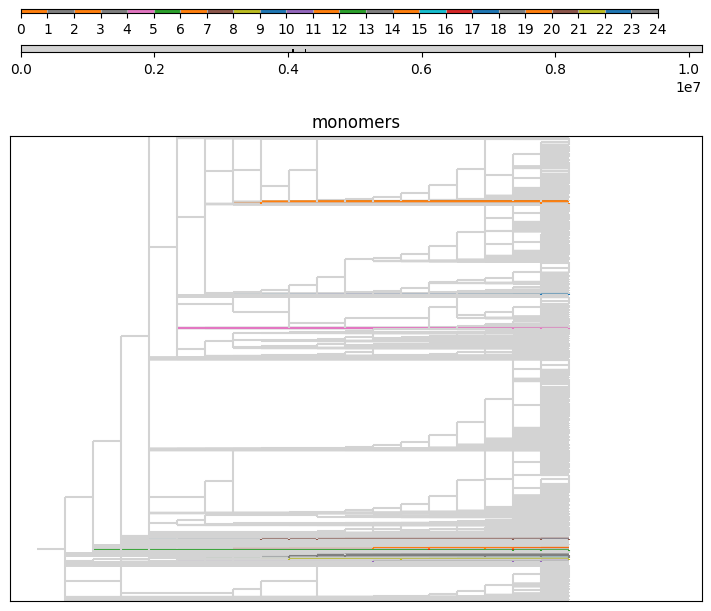

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


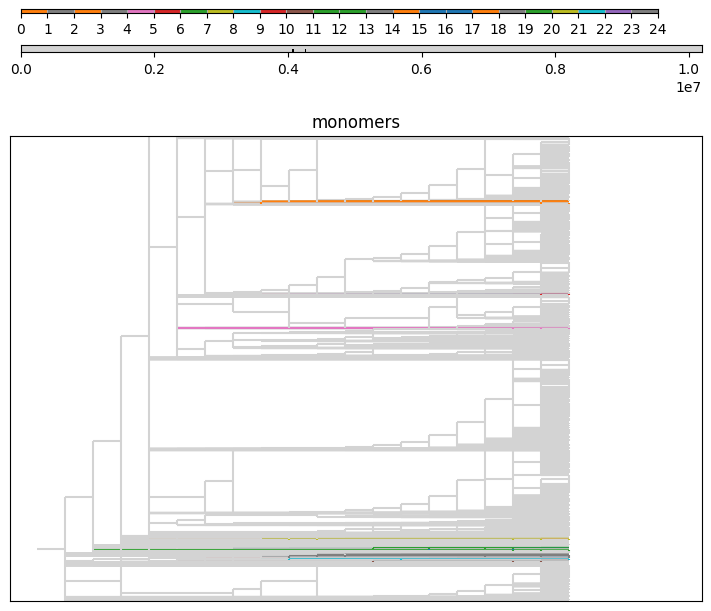

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


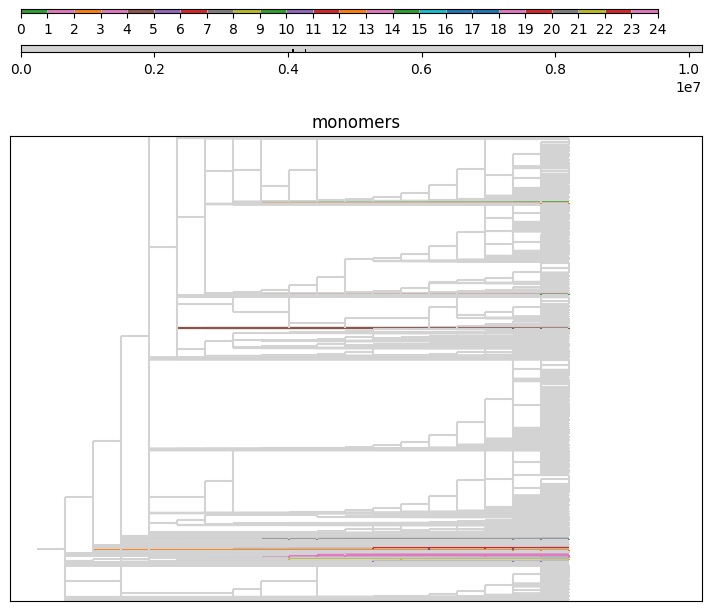

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


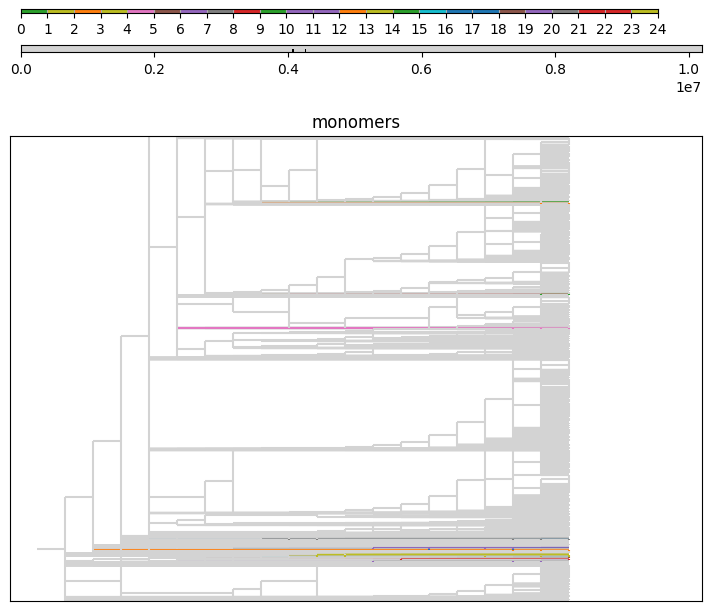

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


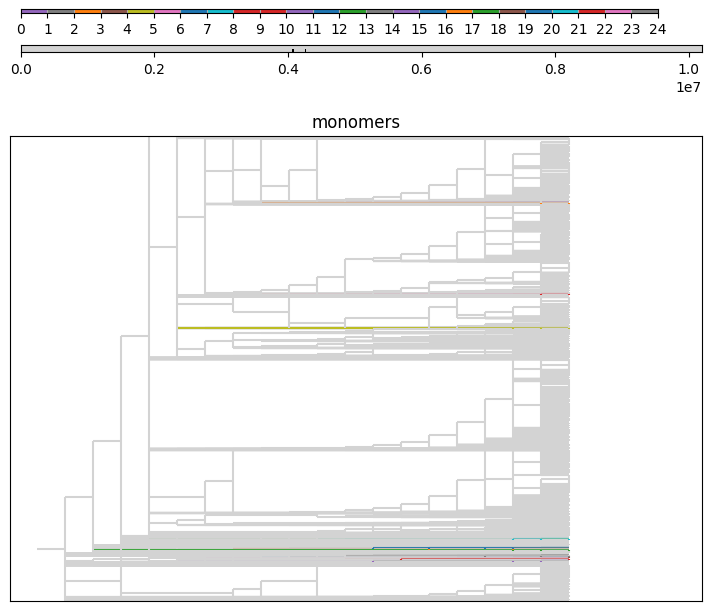

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


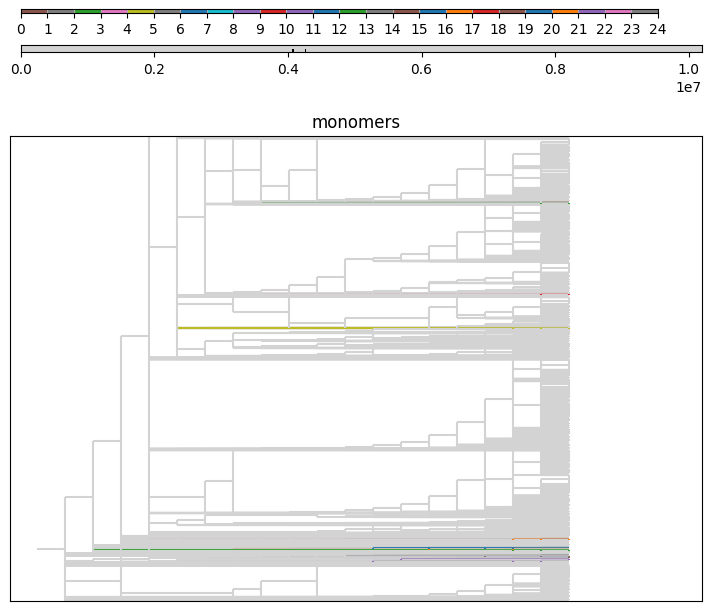

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


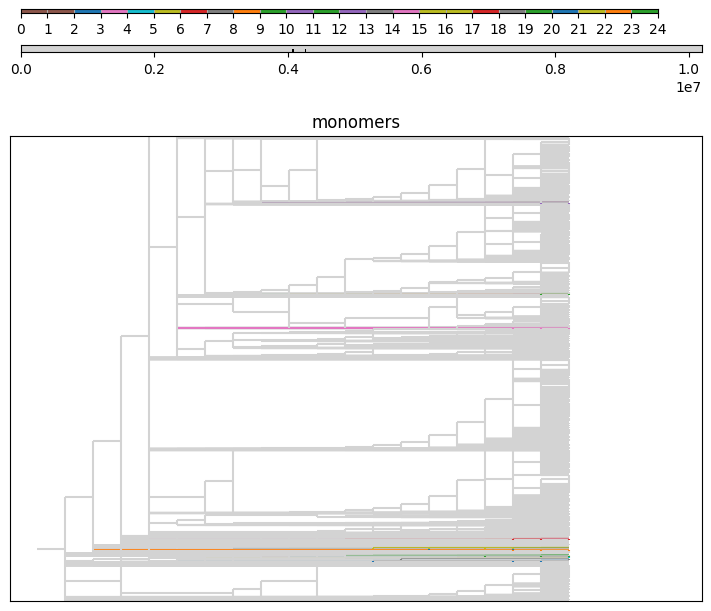

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


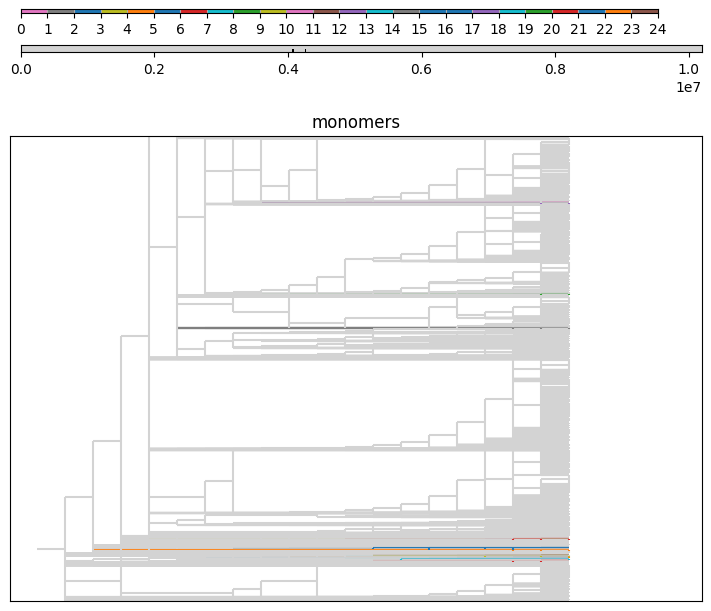

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


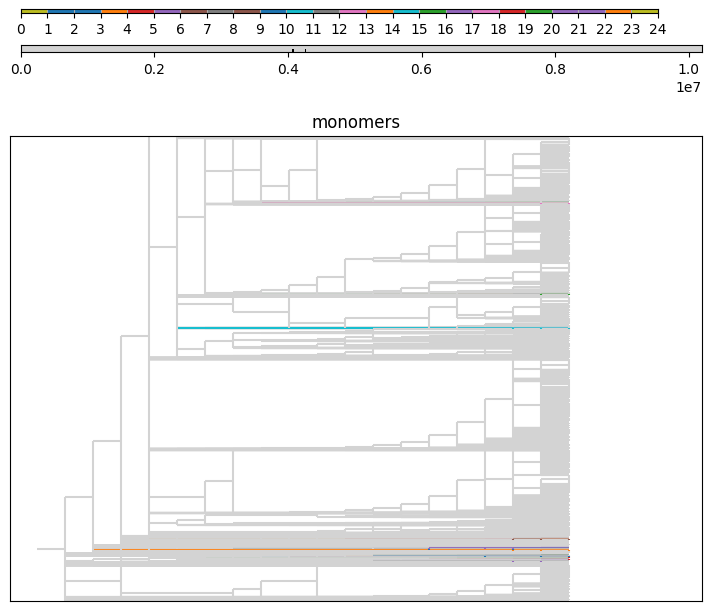

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


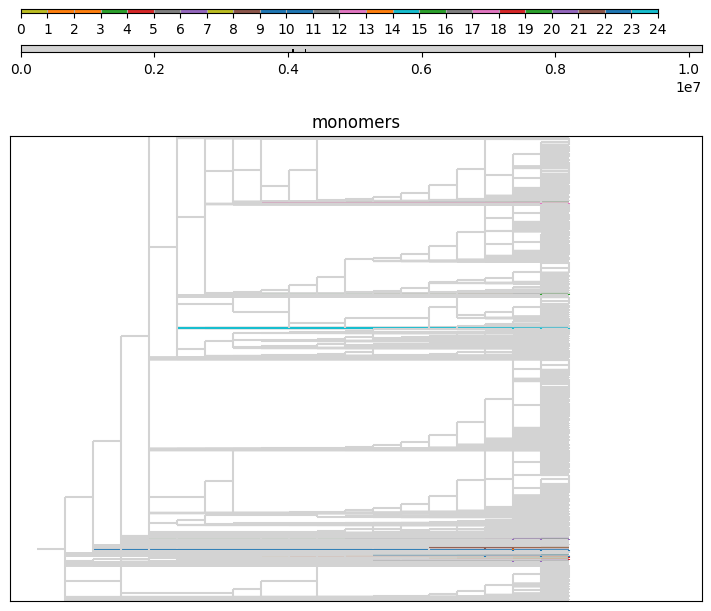

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


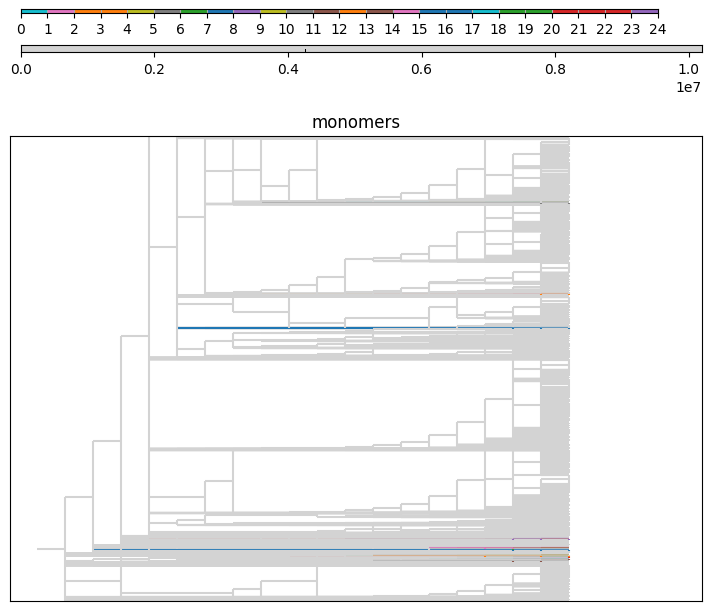

Subtree: [1, 2, 6, 2, 4]


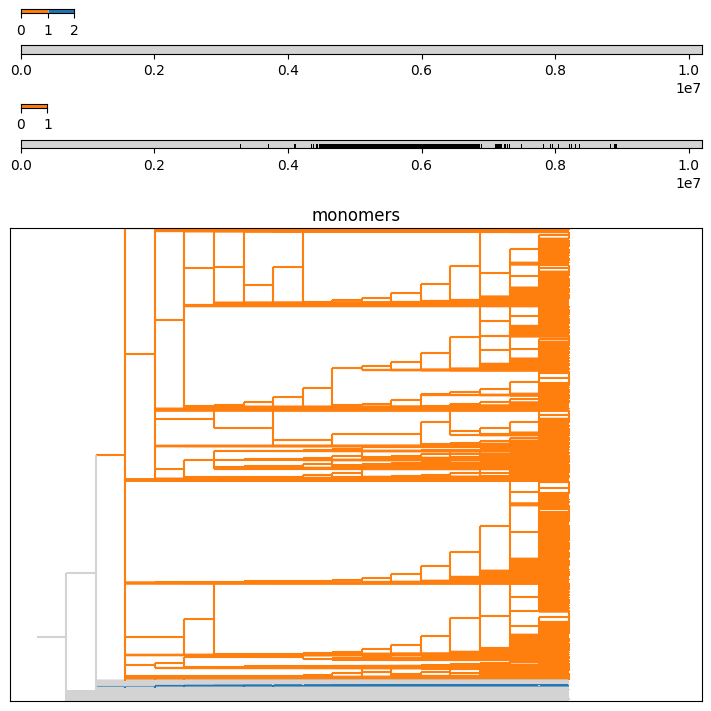

Subtree: [1, 2, 6, 2, 4, 2]


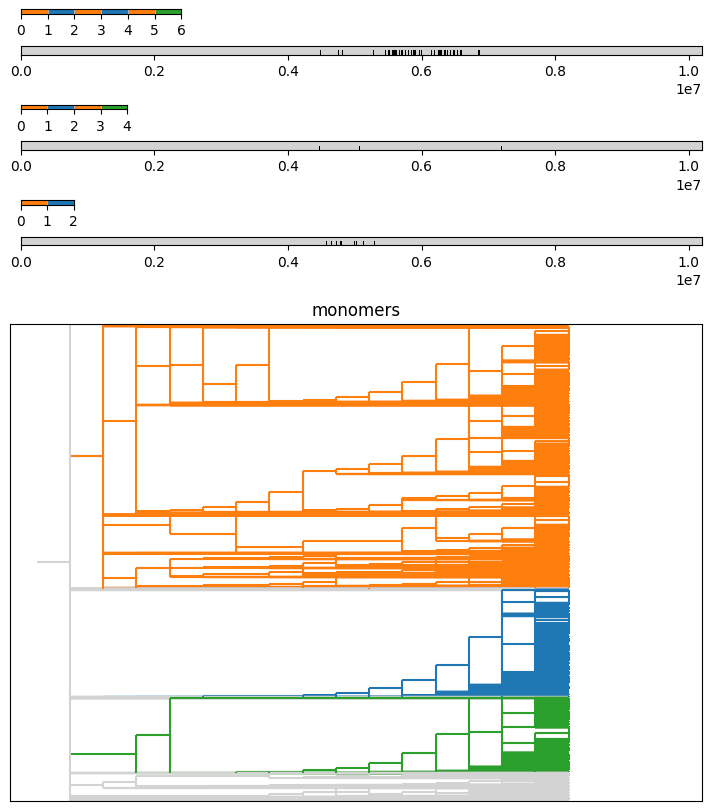

Subtree: [1, 2, 6, 2, 4, 2, 1]


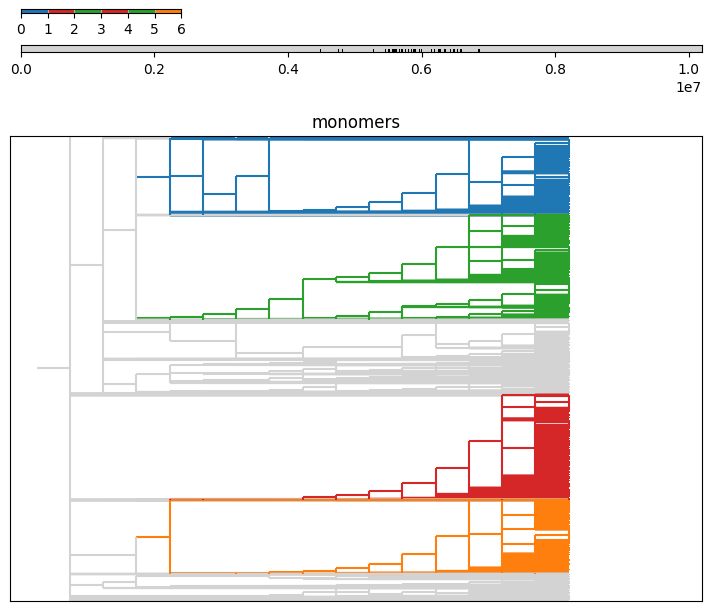

Subtree: [1, 2, 6, 2, 4, 2, 1, 1]


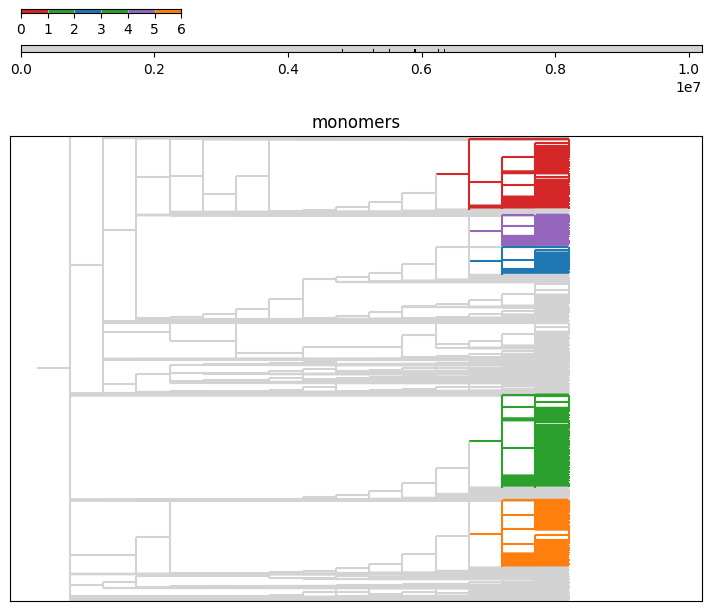

Subtree: [1, 2, 6, 2, 4, 2, 2]


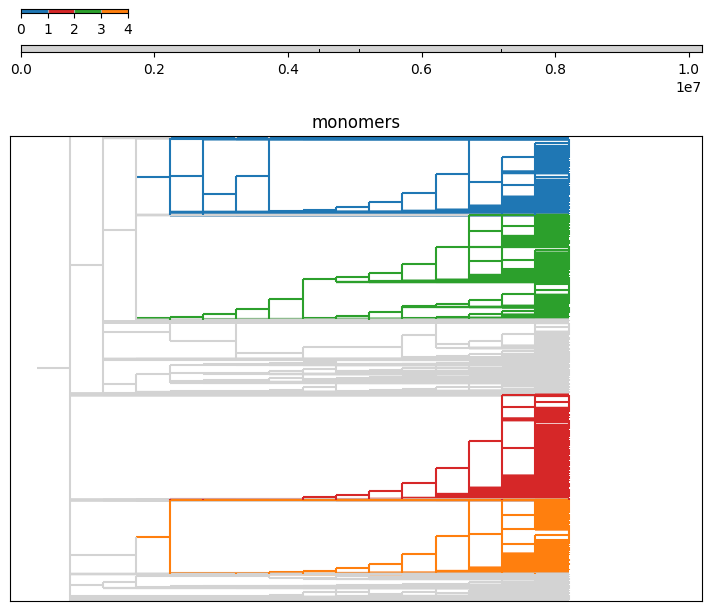

In [18]:
show_hor_tree(hor_tree_root=hor_tree.as_hor_in_seq, reference_seq=references[reference_seq_id], tree=phylogeny)

In [19]:
hor_tree_discrete = phylogeny_to_hor_tree(phylogeny, min_loops=5, allow_hor_overlap=False, discrete_sorted_levels=True)

In [20]:
phyloXml = Phyloxml(phylogenies=[hor_tree_discrete.as_phyloxml], attributes=None)
PhyloXMLIO.write(phyloXml, f"{data_path}/HORs_discrete.xml")

1

Subtree: []


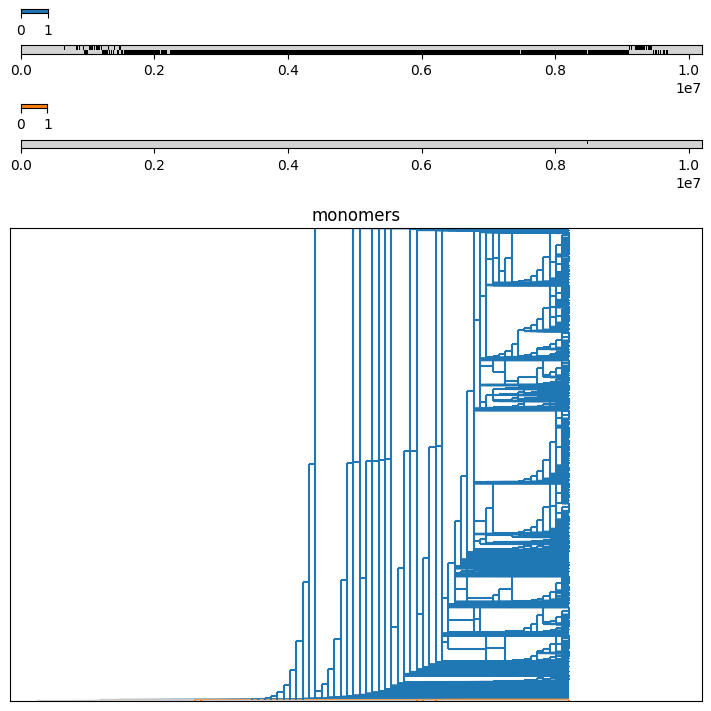

Subtree: [1]


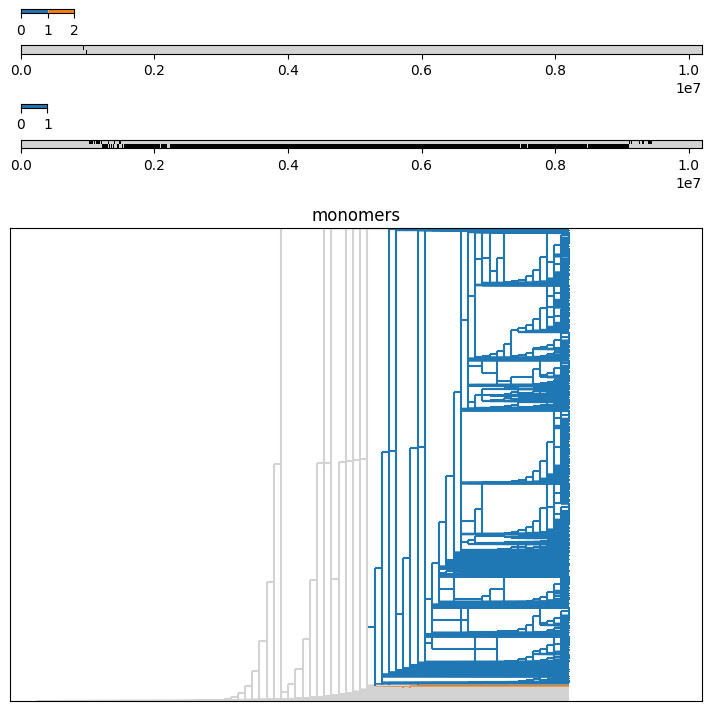

Subtree: [1, 2]


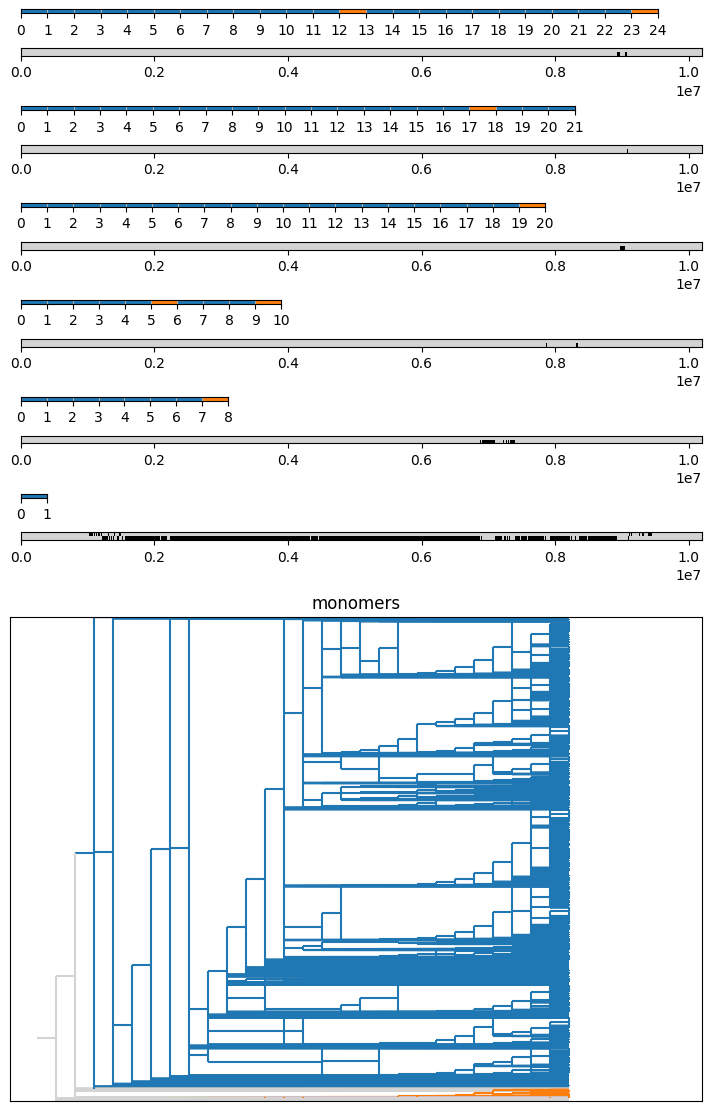

Subtree: [1, 2, 1]


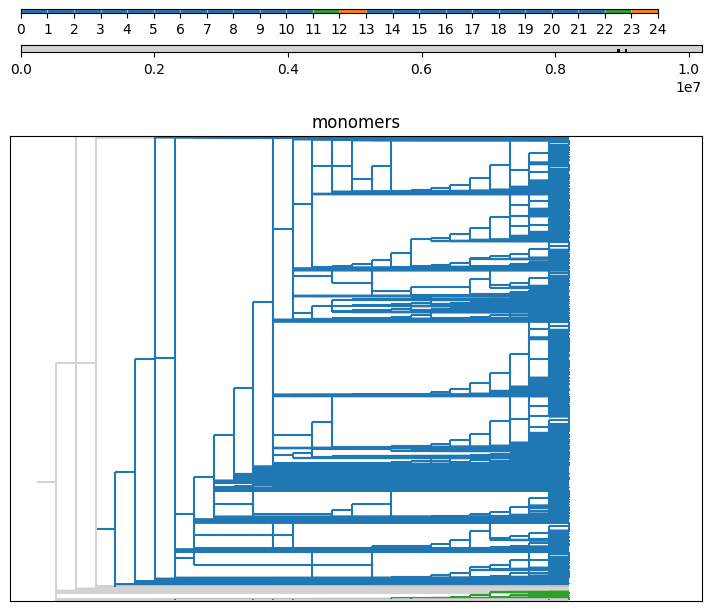

Subtree: [1, 2, 1, 1]


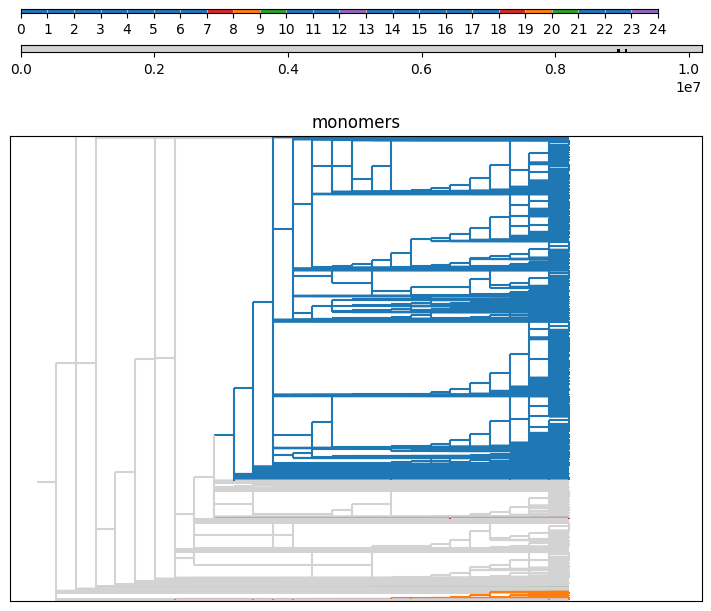

Subtree: [1, 2, 1, 1, 1]


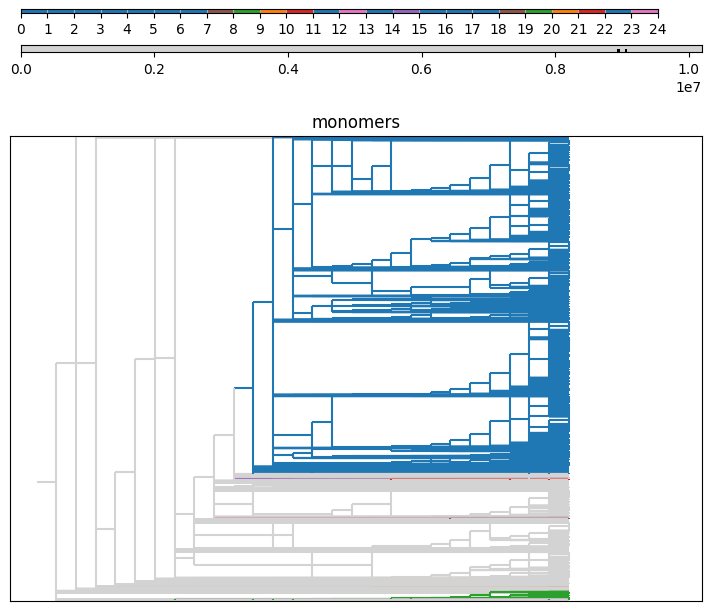

Subtree: [1, 2, 1, 1, 1, 1]


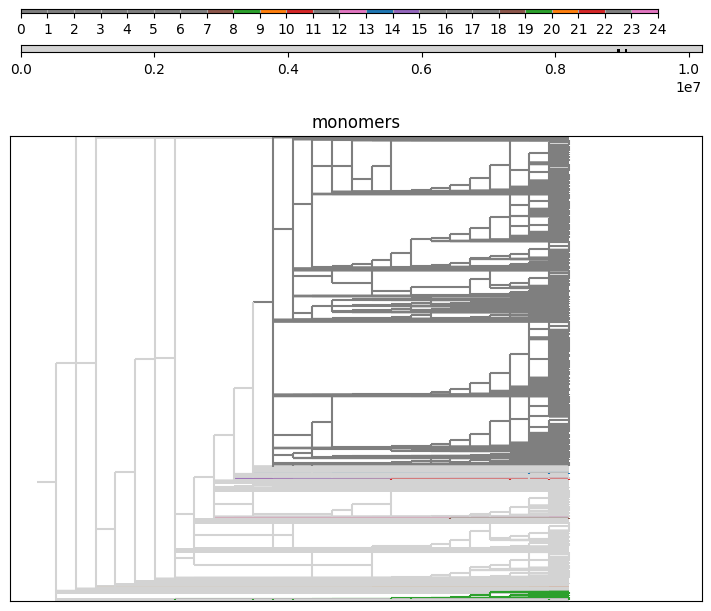

Subtree: [1, 2, 1, 1, 1, 1, 1]


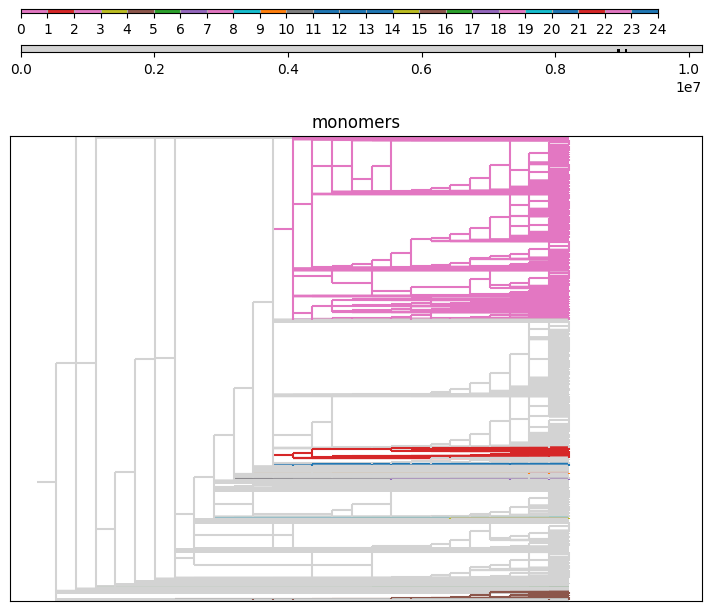

Subtree: [1, 2, 1, 1, 1, 1, 1, 1]


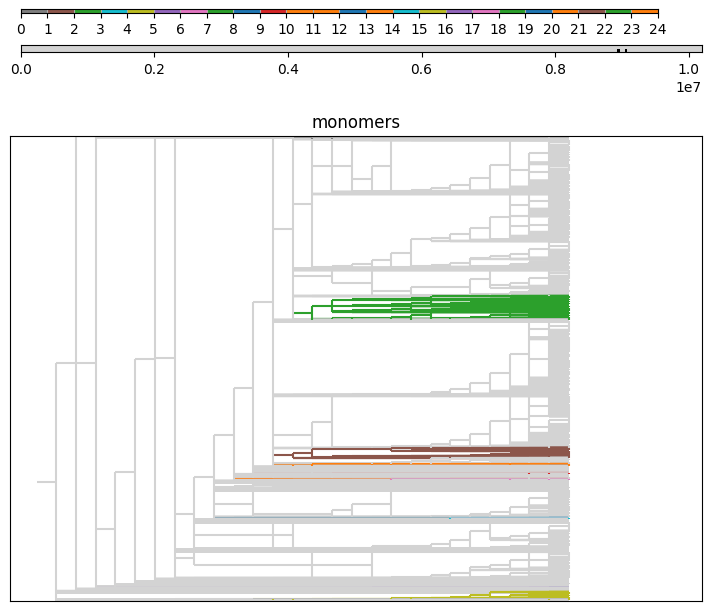

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1]


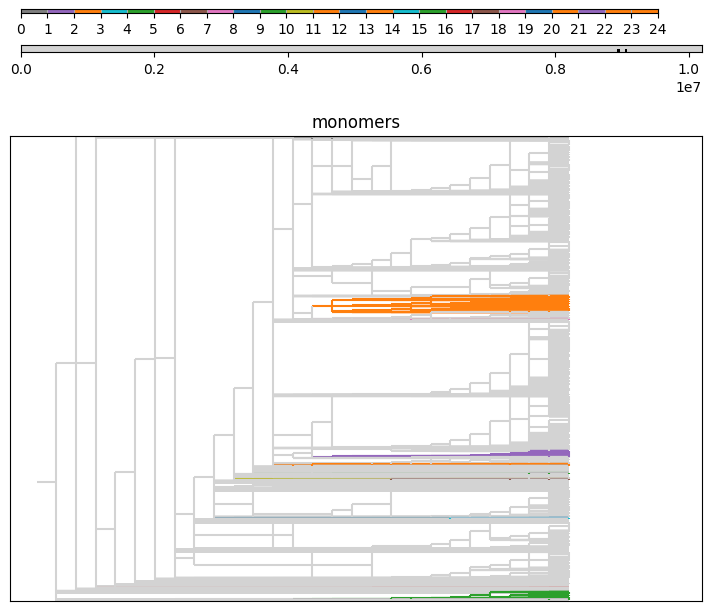

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1]


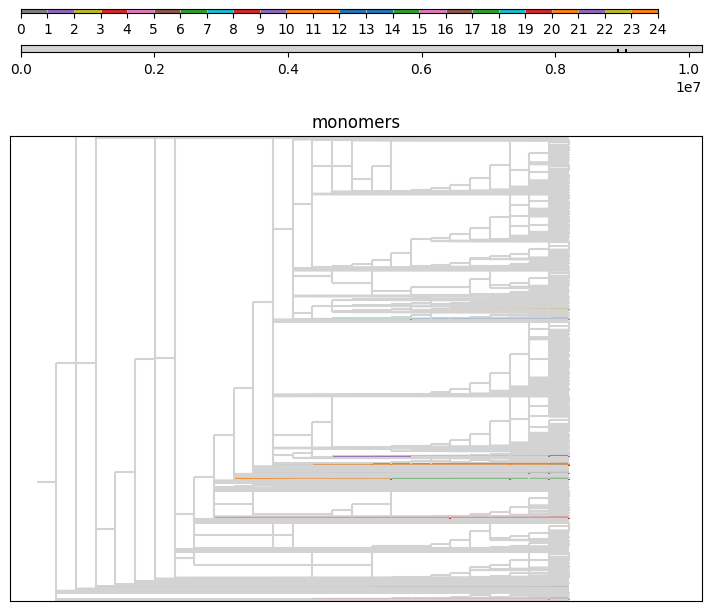

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


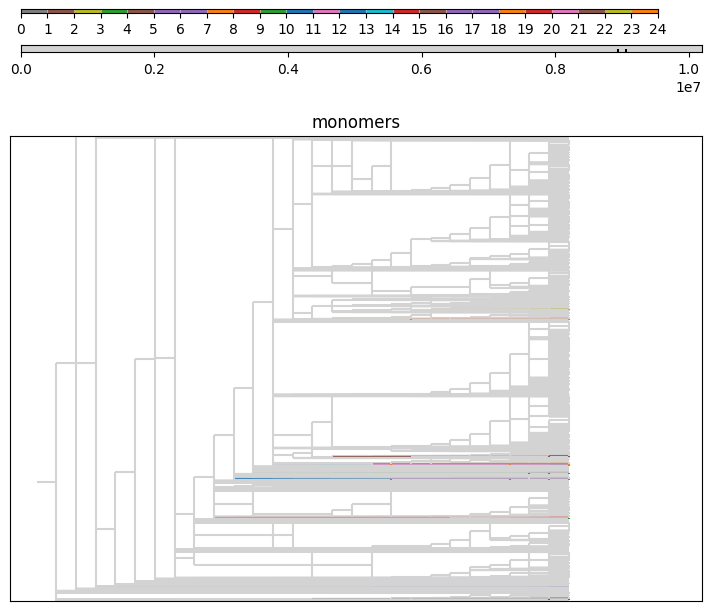

Subtree: [1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


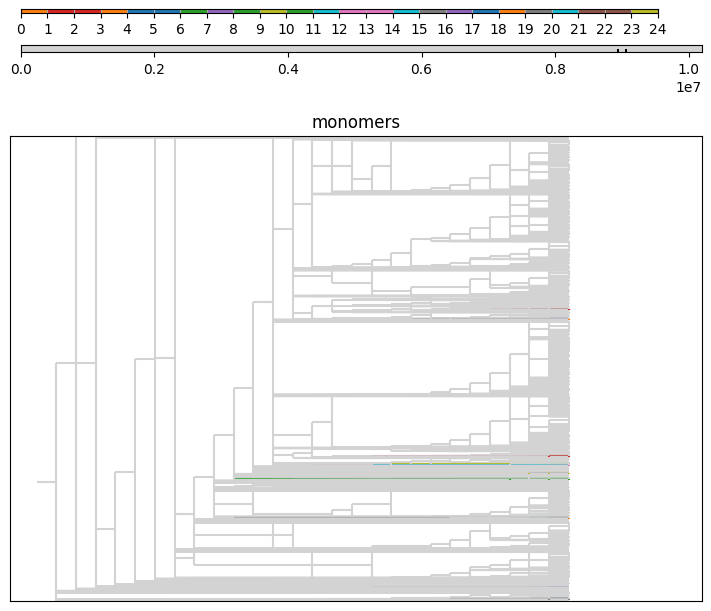

Subtree: [1, 2, 3]


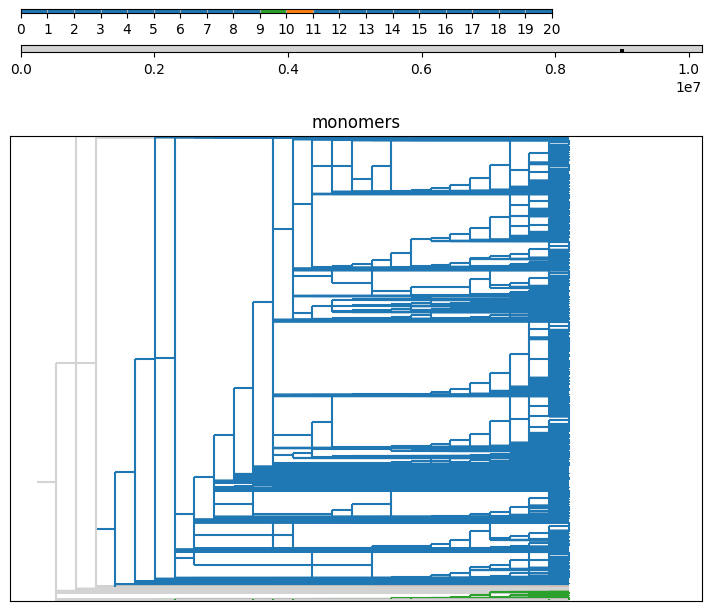

Subtree: [1, 2, 3, 1]


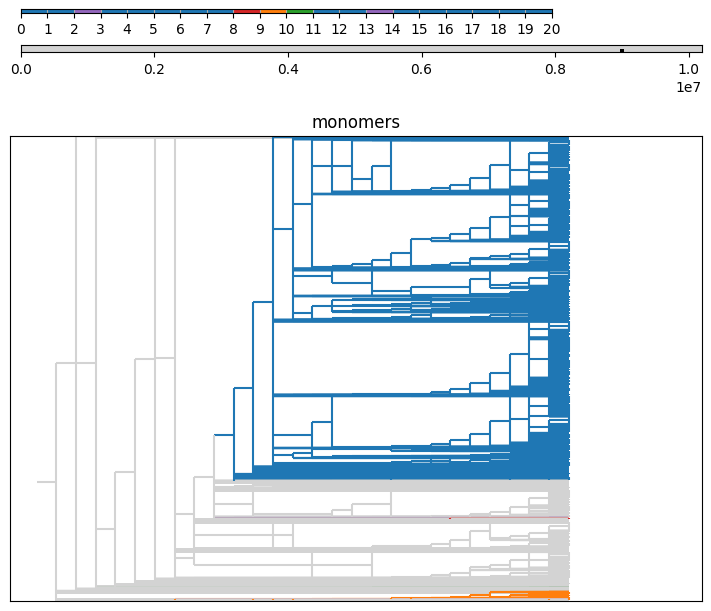

Subtree: [1, 2, 3, 1, 1]


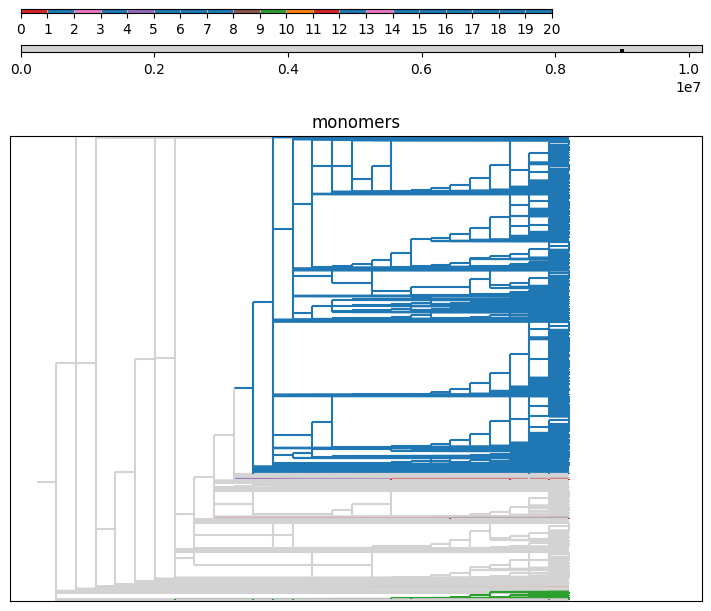

Subtree: [1, 2, 3, 1, 1, 1]


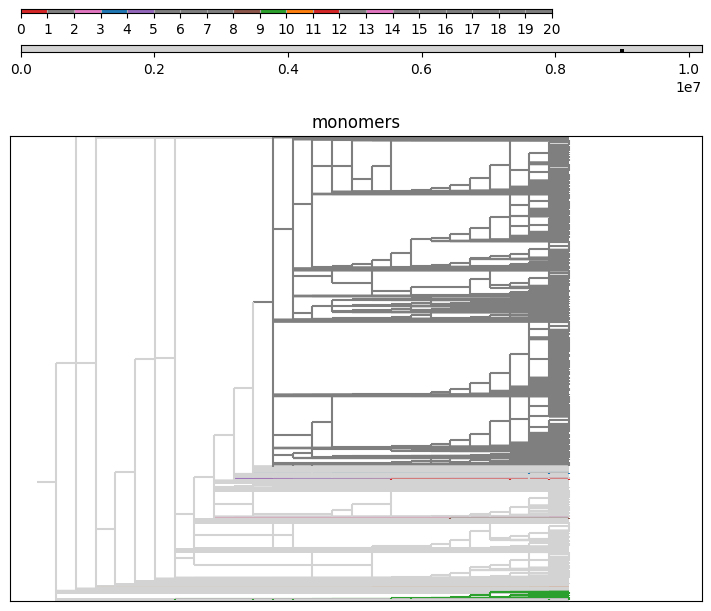

Subtree: [1, 2, 3, 1, 1, 1, 1]


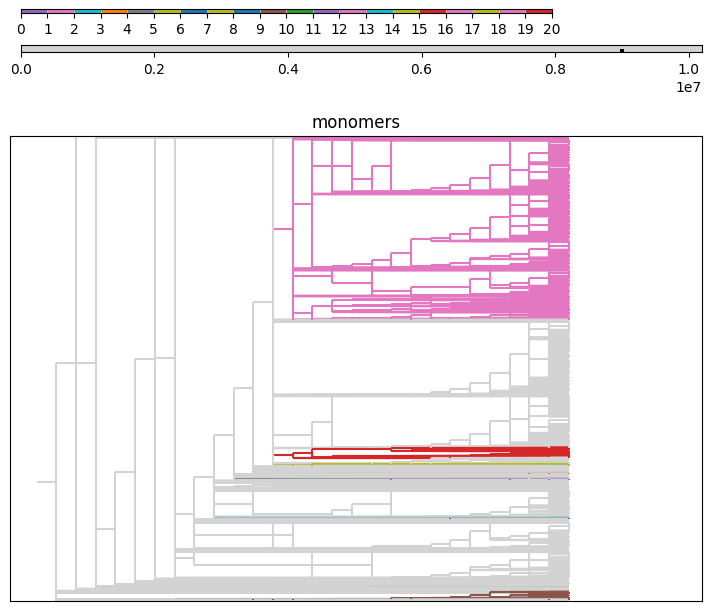

Subtree: [1, 2, 3, 1, 1, 1, 1, 1]


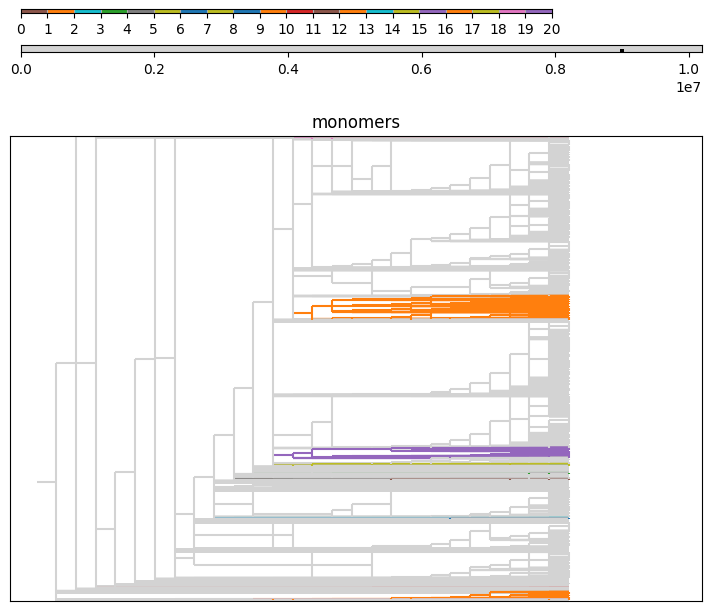

Subtree: [1, 2, 3, 1, 1, 1, 1, 1, 1]


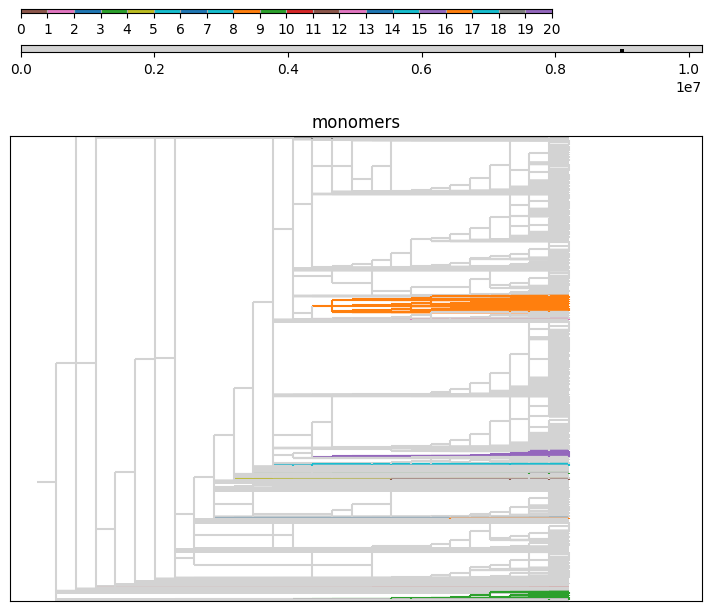

Subtree: [1, 2, 3, 1, 1, 1, 1, 1, 1, 1]


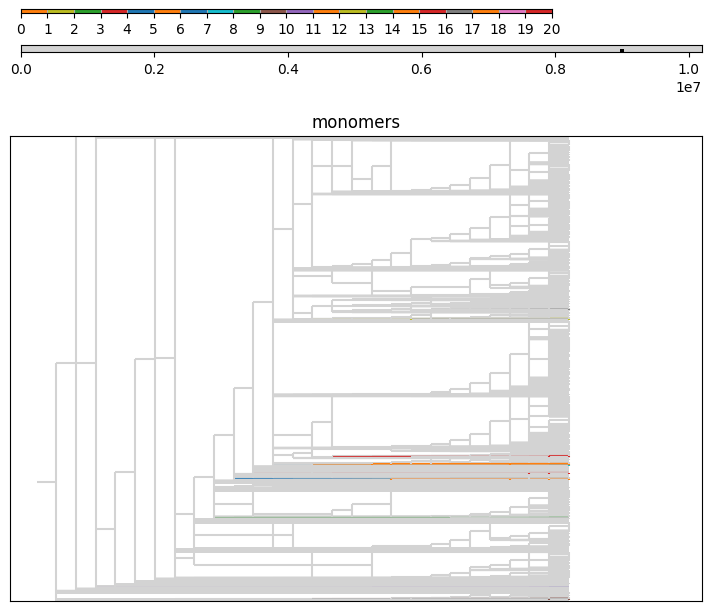

Subtree: [1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1]


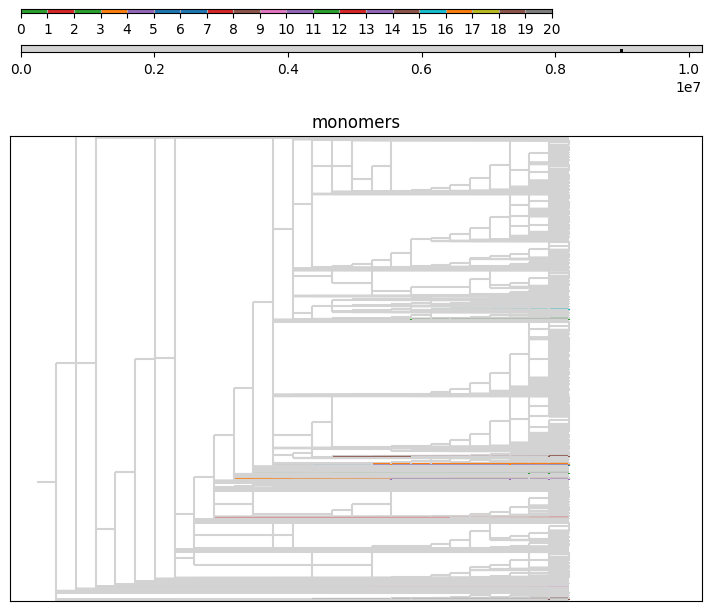

Subtree: [1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1]


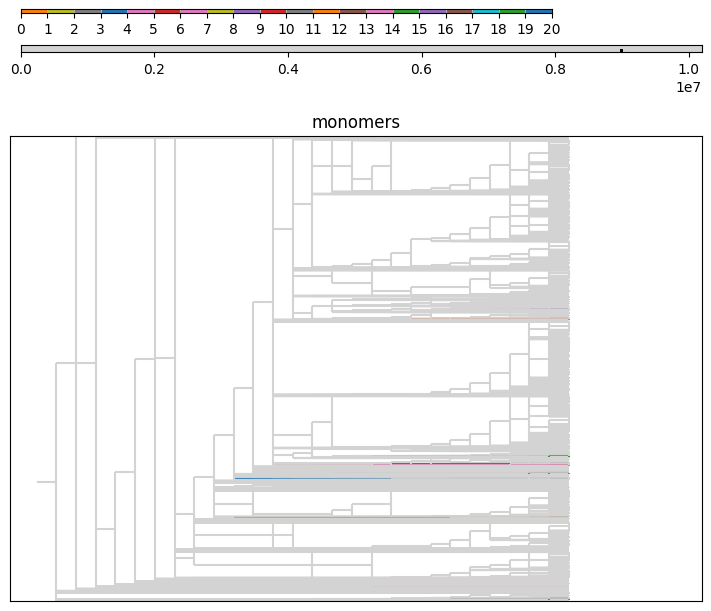

Subtree: [1, 2, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


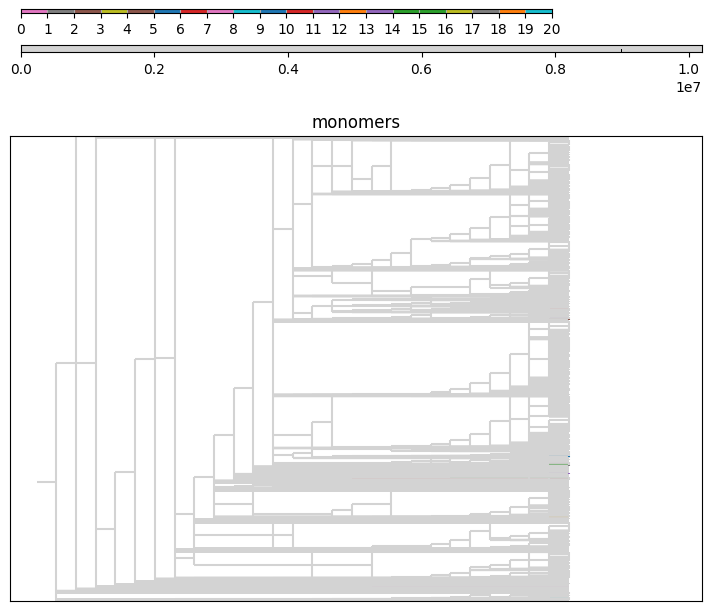

Subtree: [1, 2, 4]


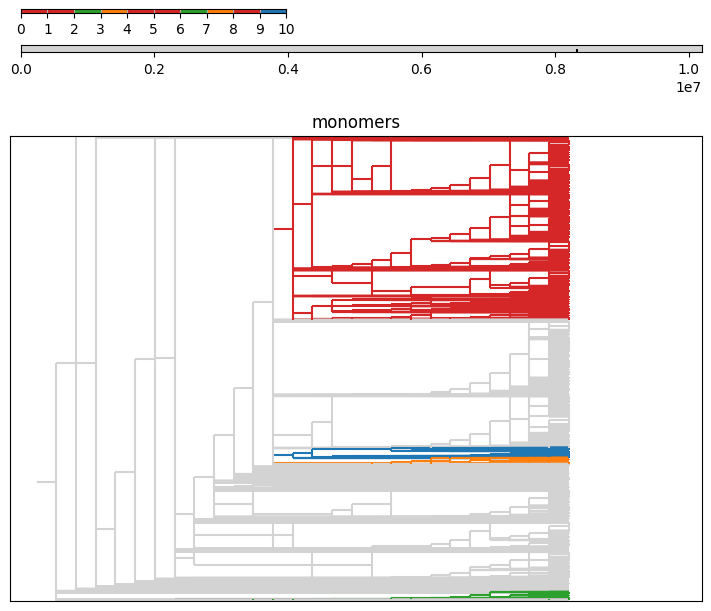

Subtree: [1, 2, 4, 1]


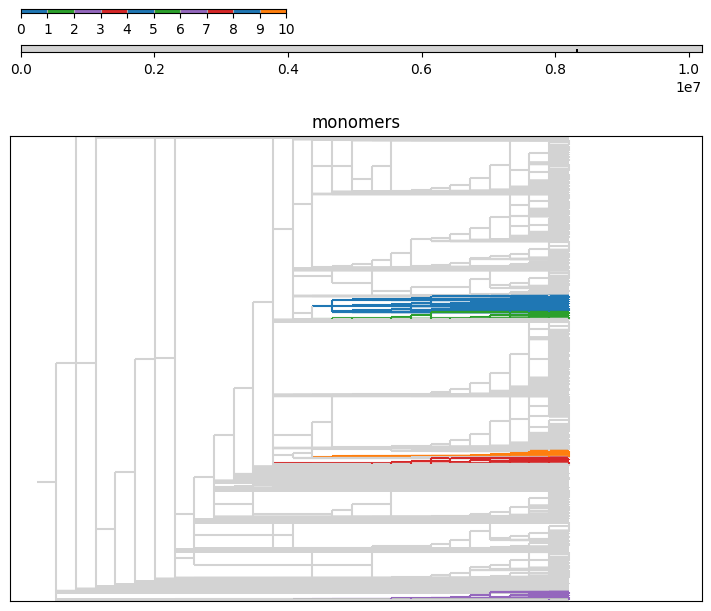

Subtree: [1, 2, 4, 1, 1]


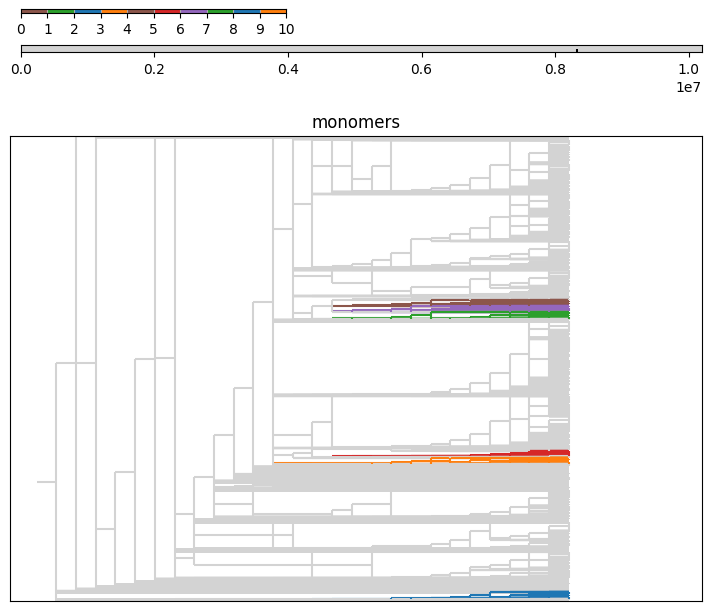

Subtree: [1, 2, 4, 1, 1, 1]


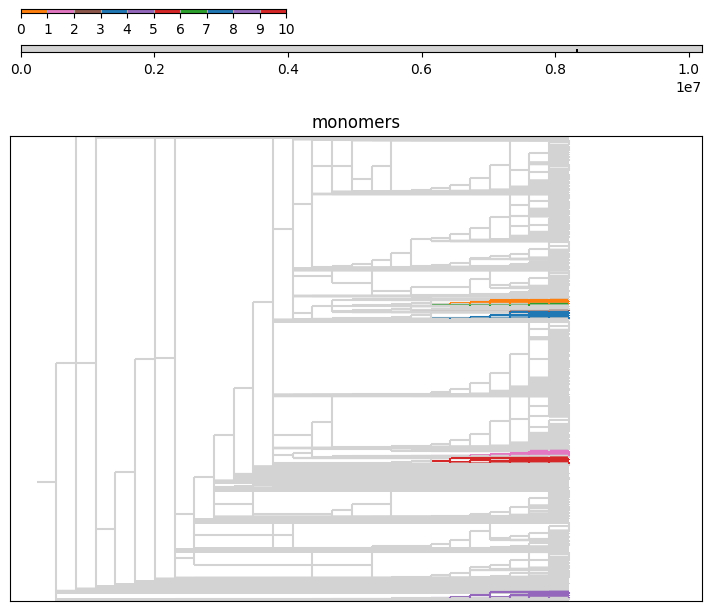

Subtree: [1, 2, 4, 1, 1, 1, 1]


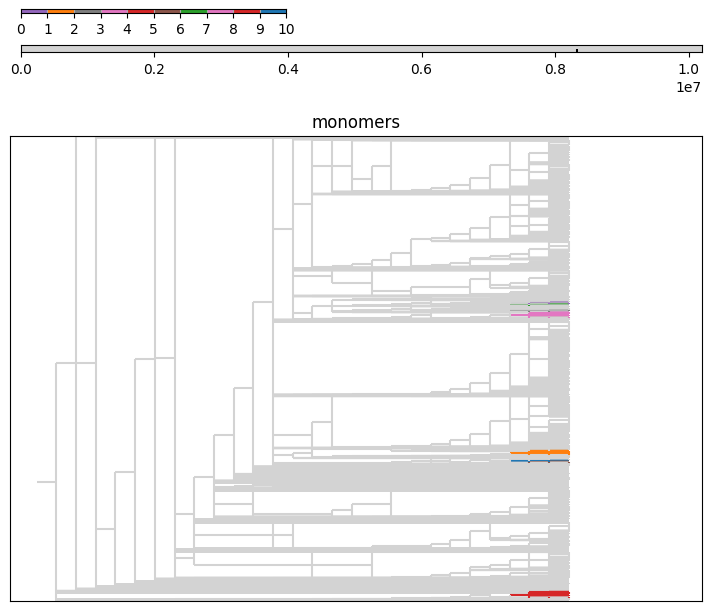

Subtree: [1, 2, 5]


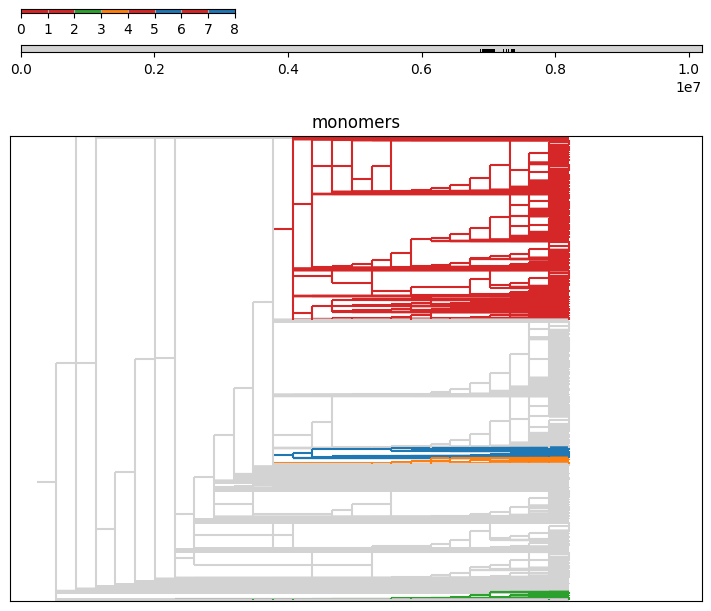

Subtree: [1, 2, 5, 1]


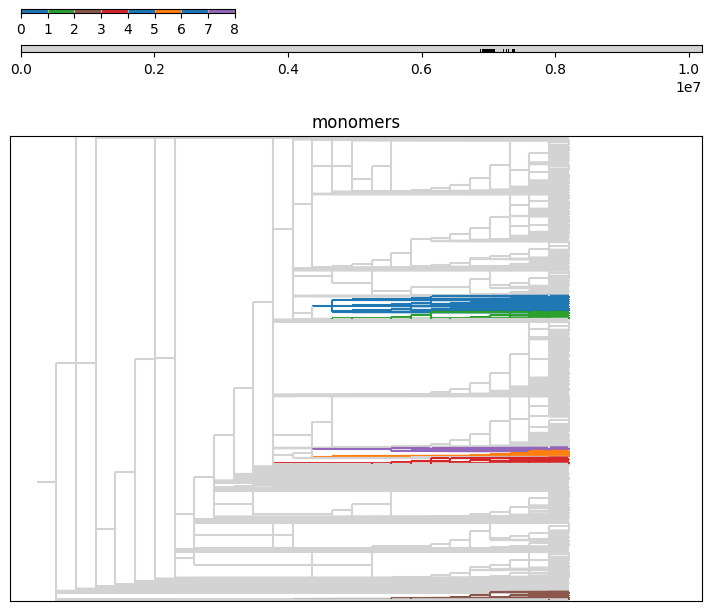

Subtree: [1, 2, 5, 1, 1]


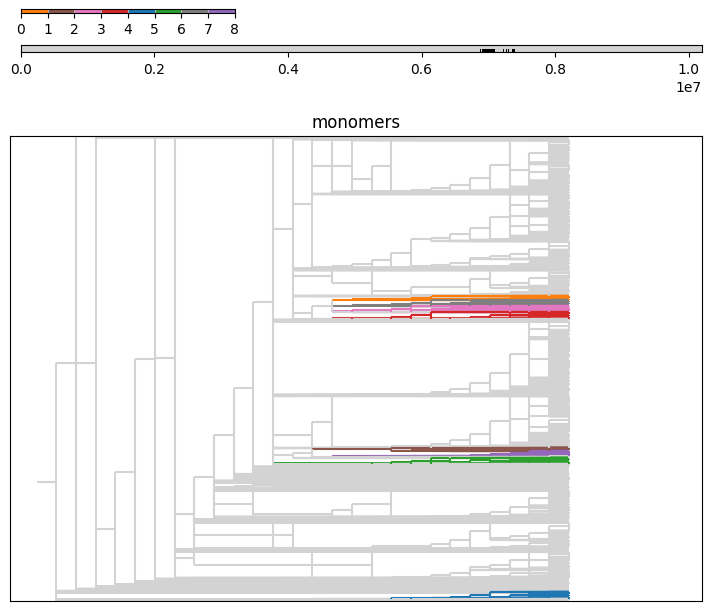

Subtree: [1, 2, 5, 1, 1, 1]


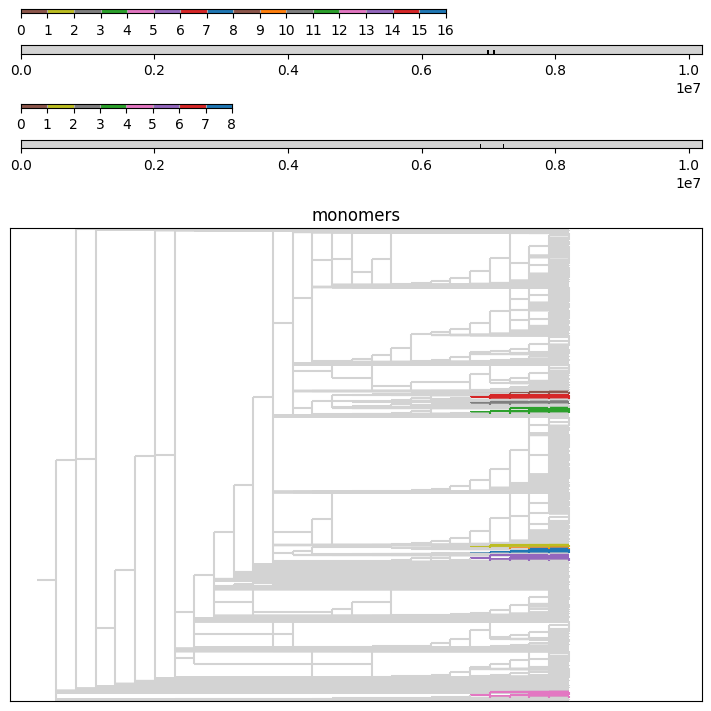

Subtree: [1, 2, 6]


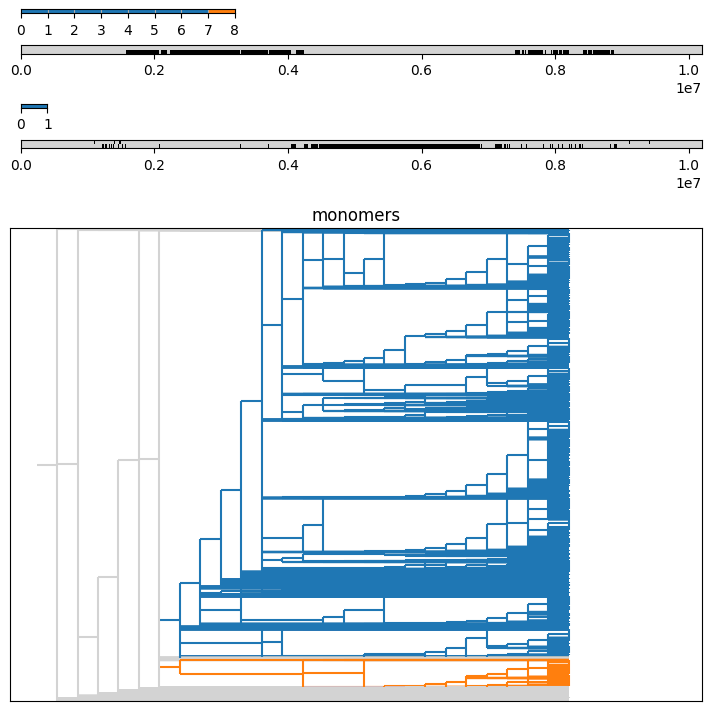

Subtree: [1, 2, 6, 1]


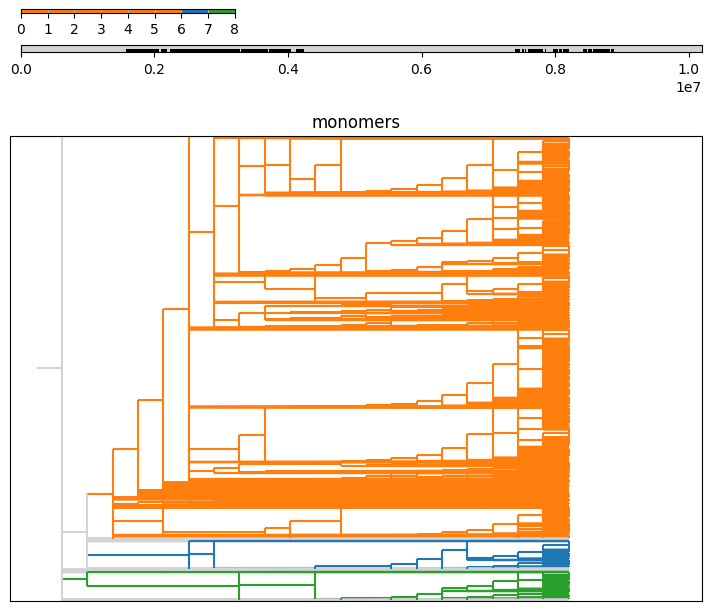

Subtree: [1, 2, 6, 1, 1]


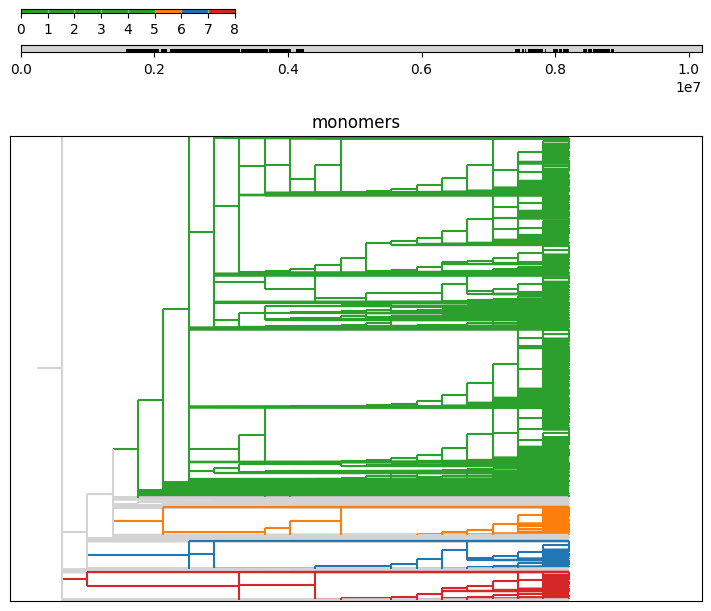

Subtree: [1, 2, 6, 1, 1, 1]


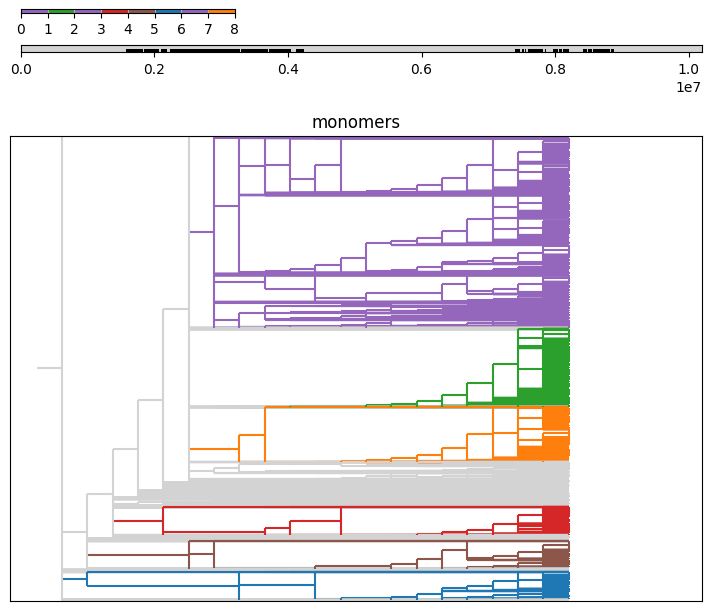

Subtree: [1, 2, 6, 1, 1, 1, 1]


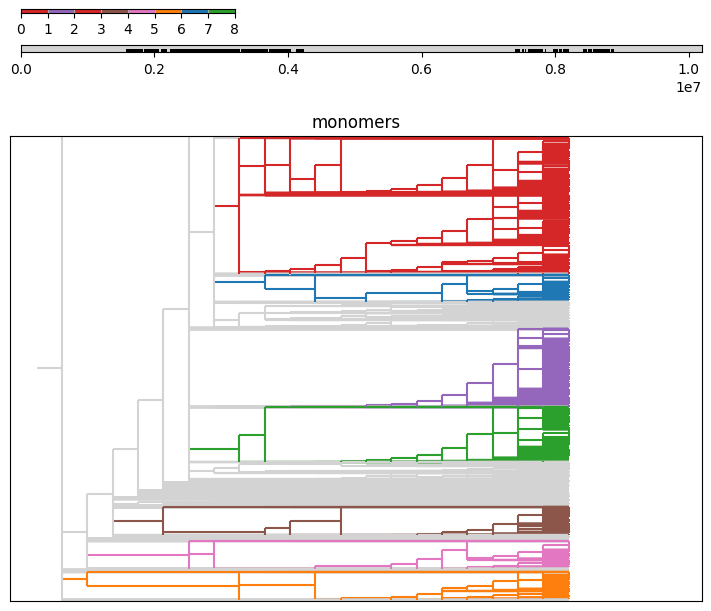

Subtree: [1, 2, 6, 1, 1, 1, 1, 1]


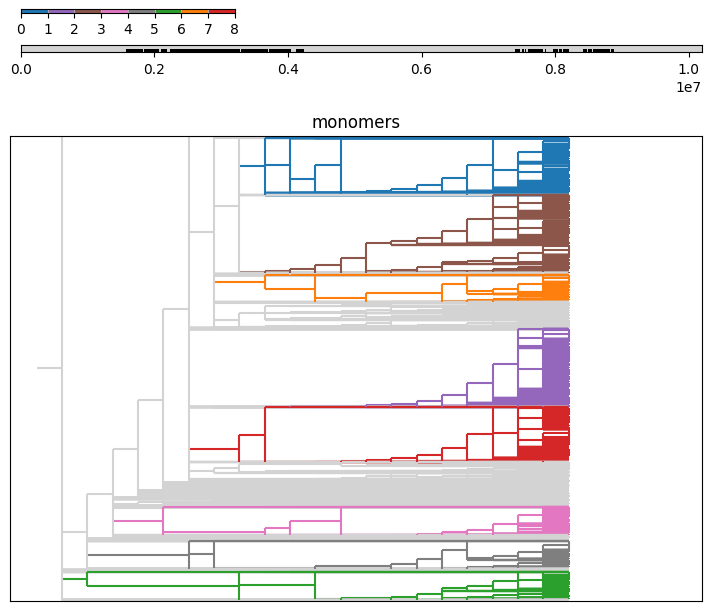

Subtree: [1, 2, 6, 1, 1, 1, 1, 1, 1]


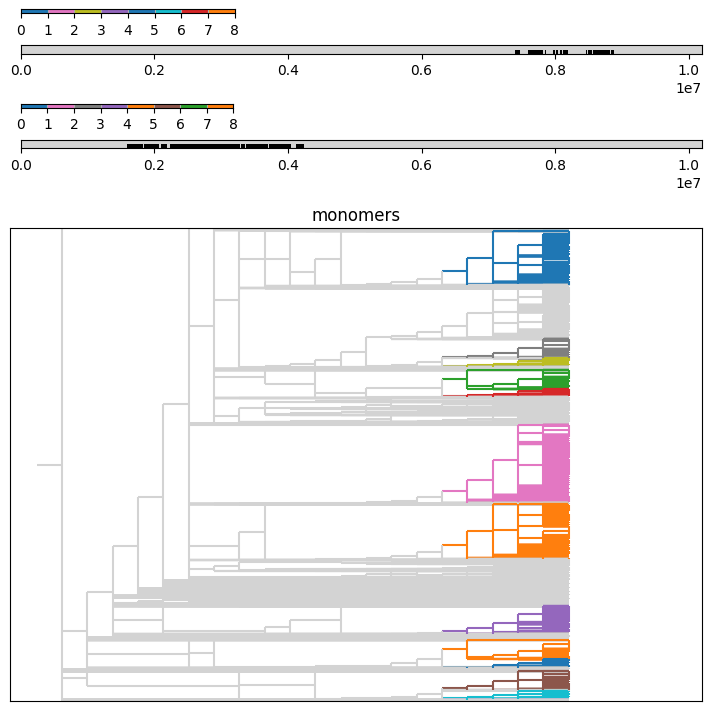

Subtree: [1, 2, 6, 1, 1, 1, 1, 1, 1, 2]


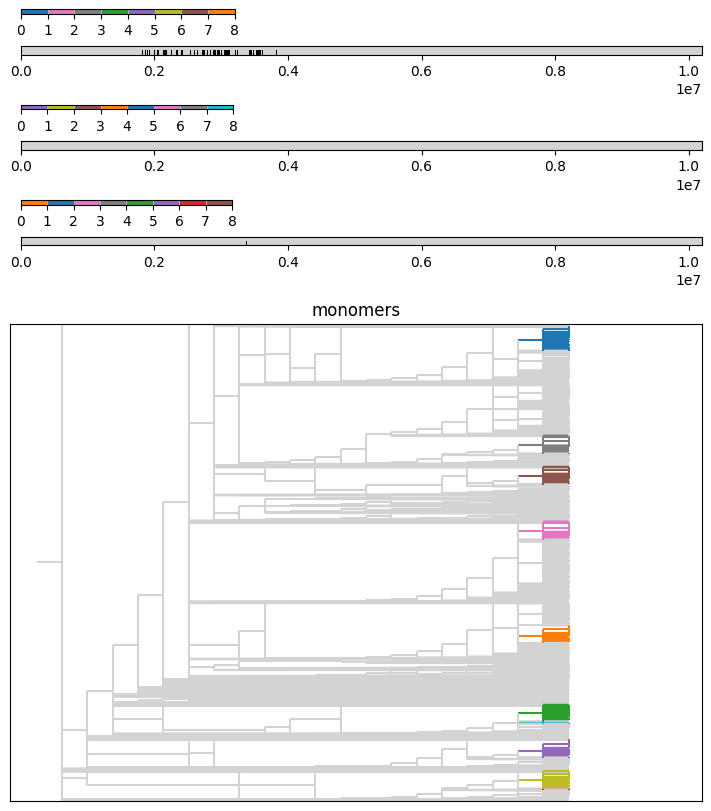

Subtree: [1, 2, 6, 2]


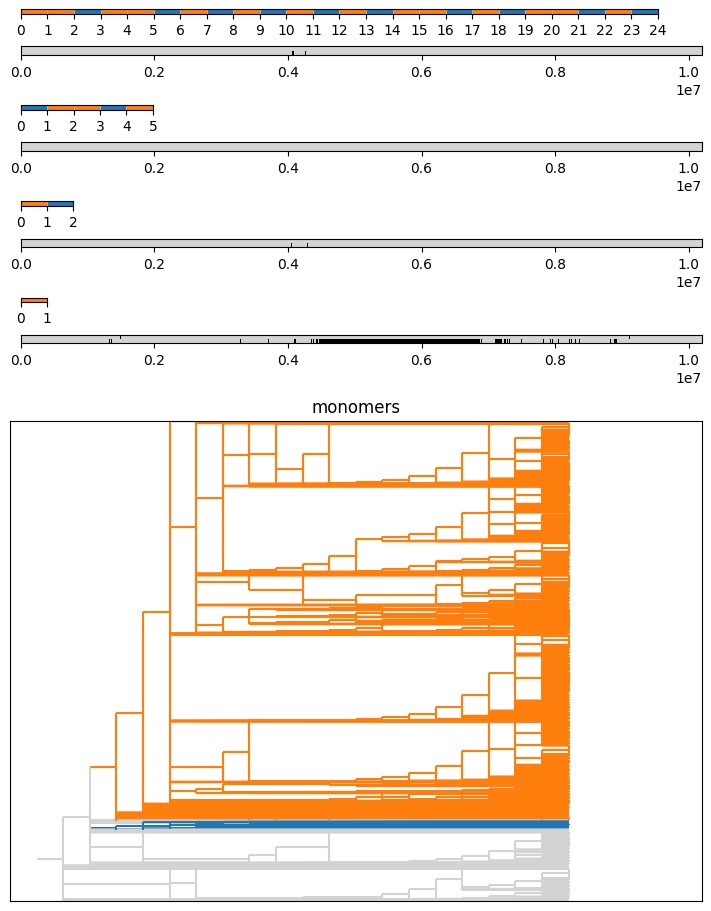

Subtree: [1, 2, 6, 2, 1]


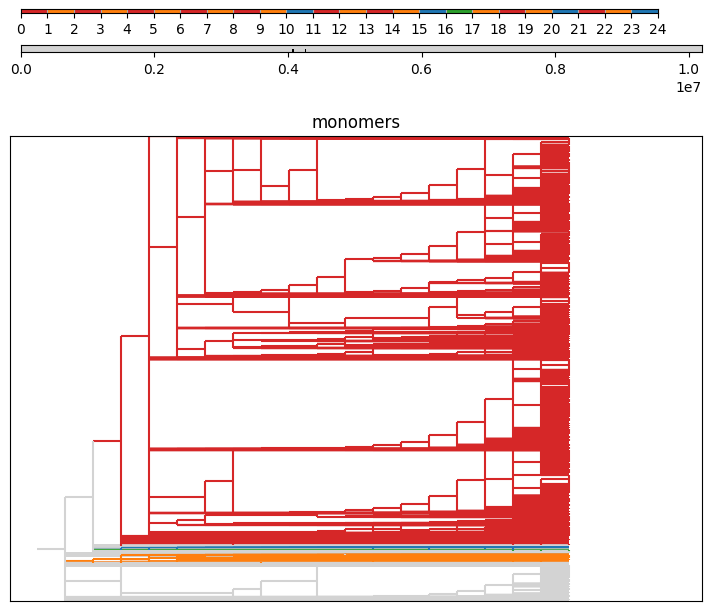

Subtree: [1, 2, 6, 2, 1, 1]


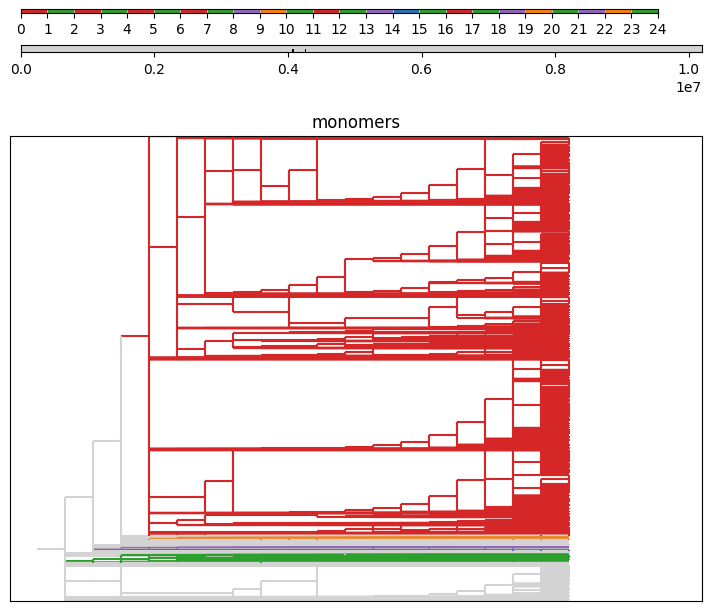

Subtree: [1, 2, 6, 2, 1, 1, 1]


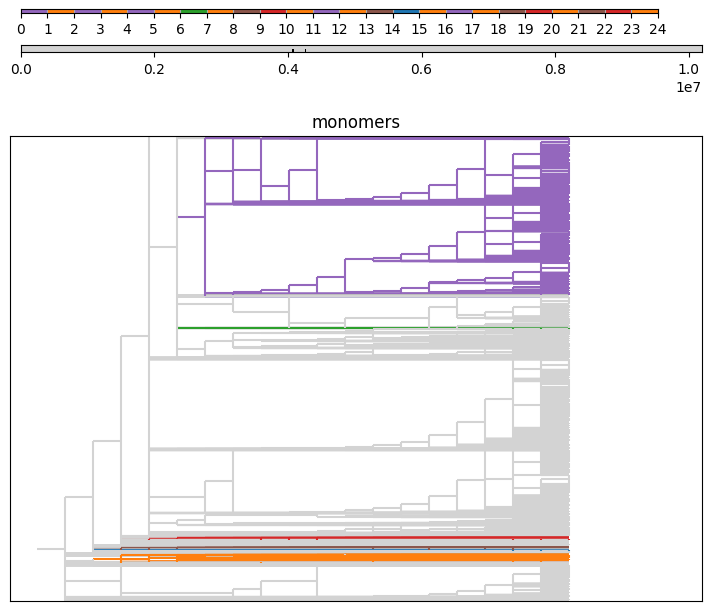

Subtree: [1, 2, 6, 2, 1, 1, 1, 1]


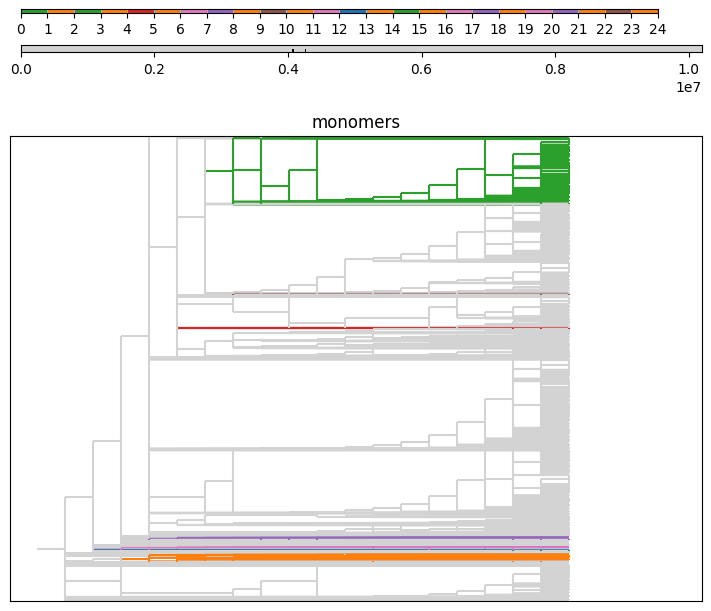

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1]


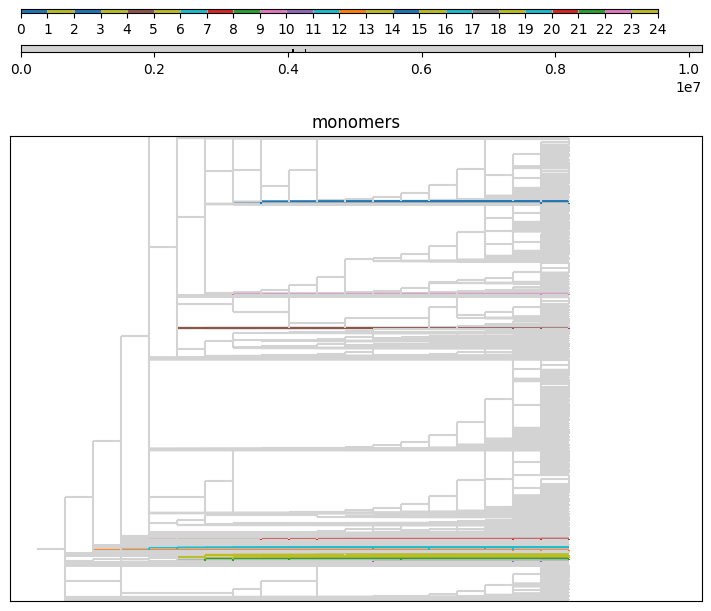

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1]


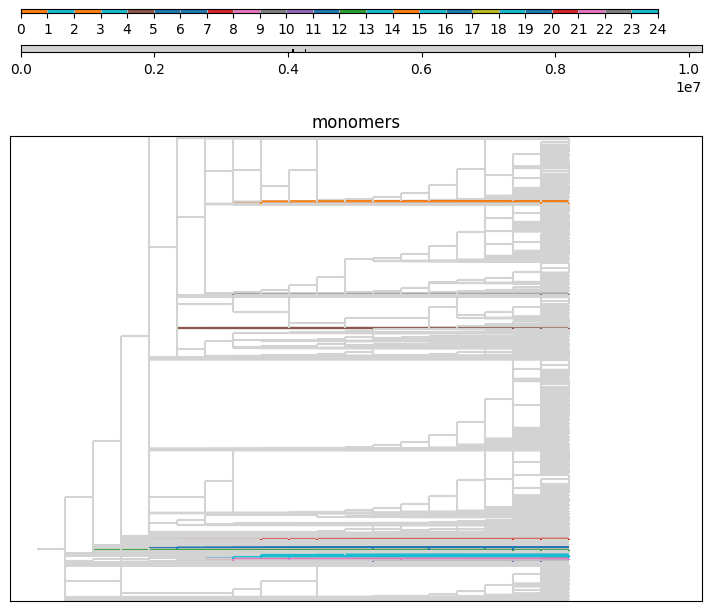

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1]


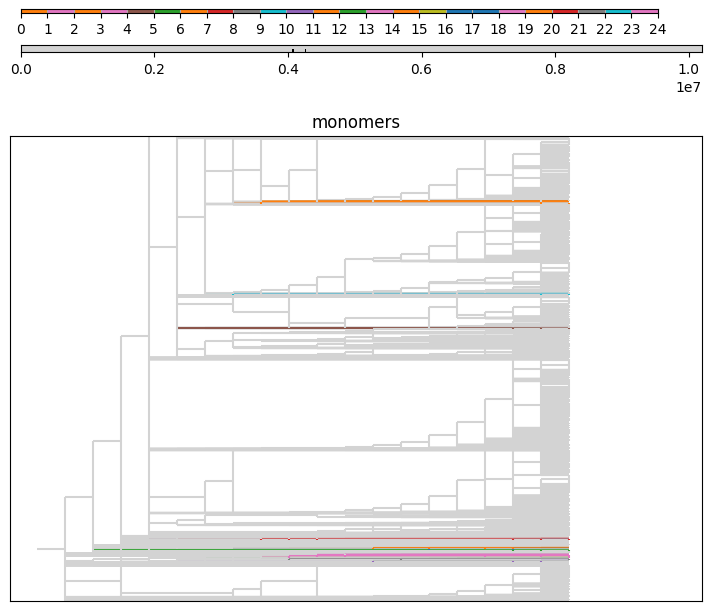

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1]


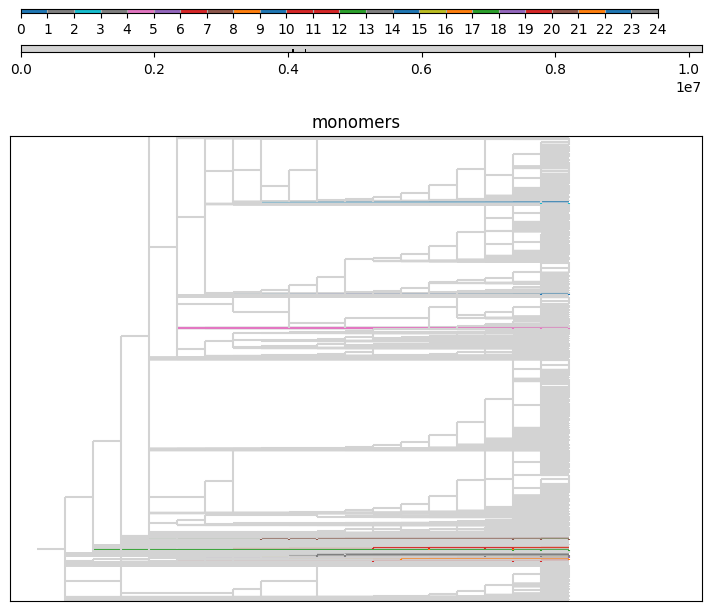

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1]


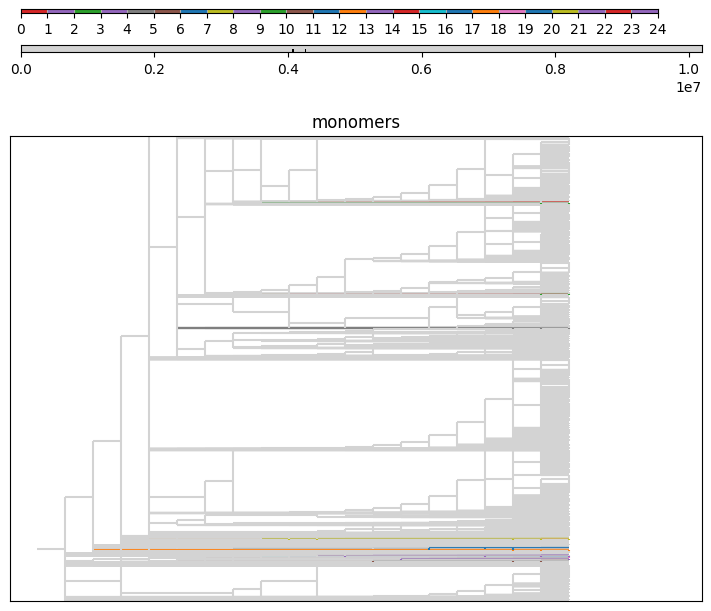

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


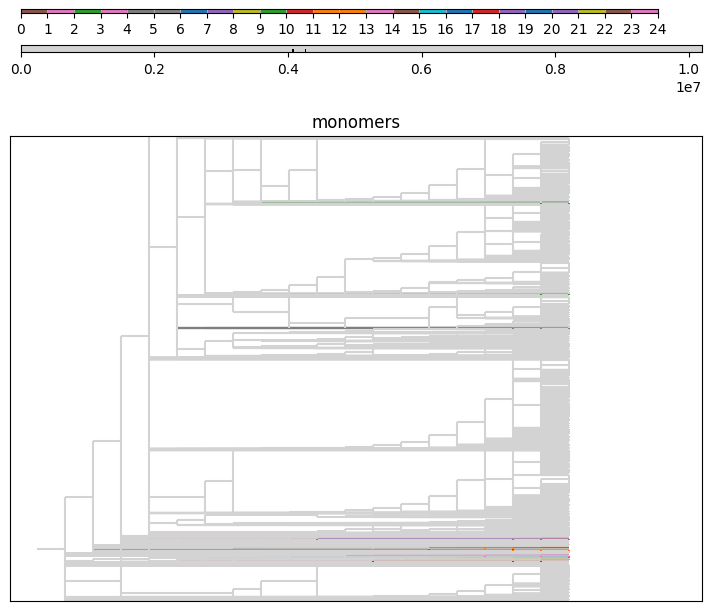

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


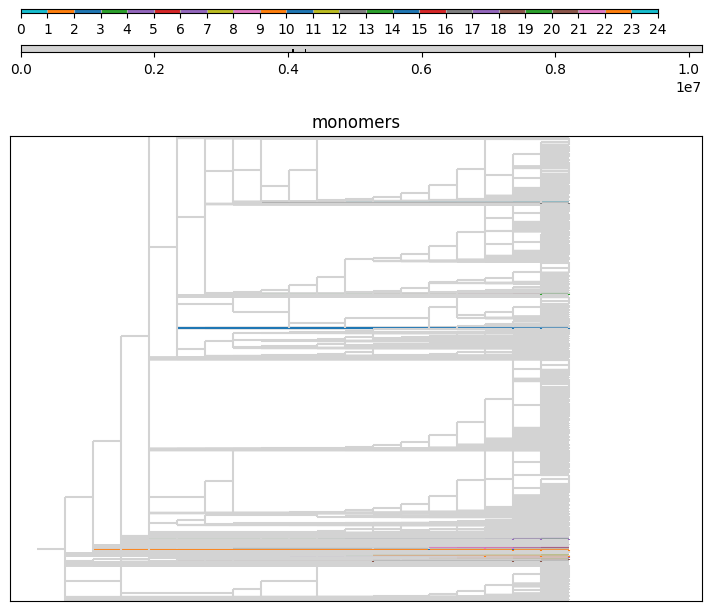

Subtree: [1, 2, 6, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


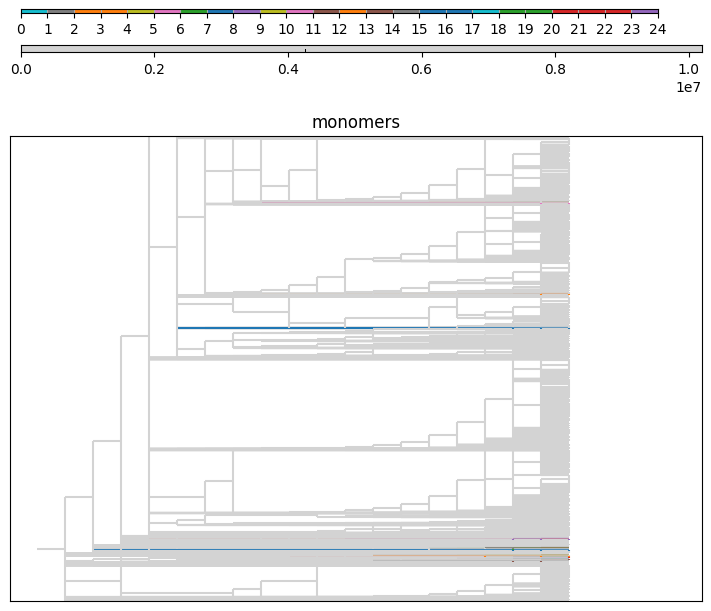

Subtree: [1, 2, 6, 2, 4]


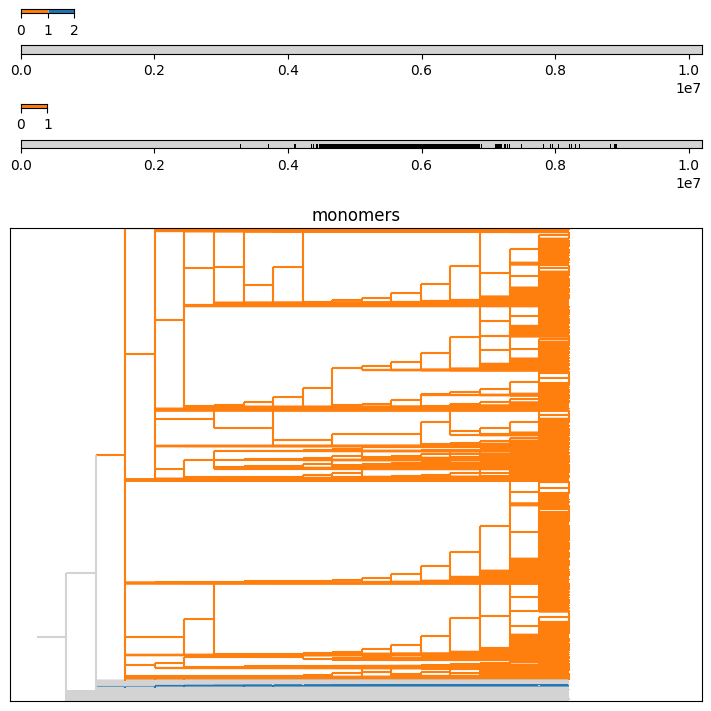

Subtree: [1, 2, 6, 2, 4, 2]


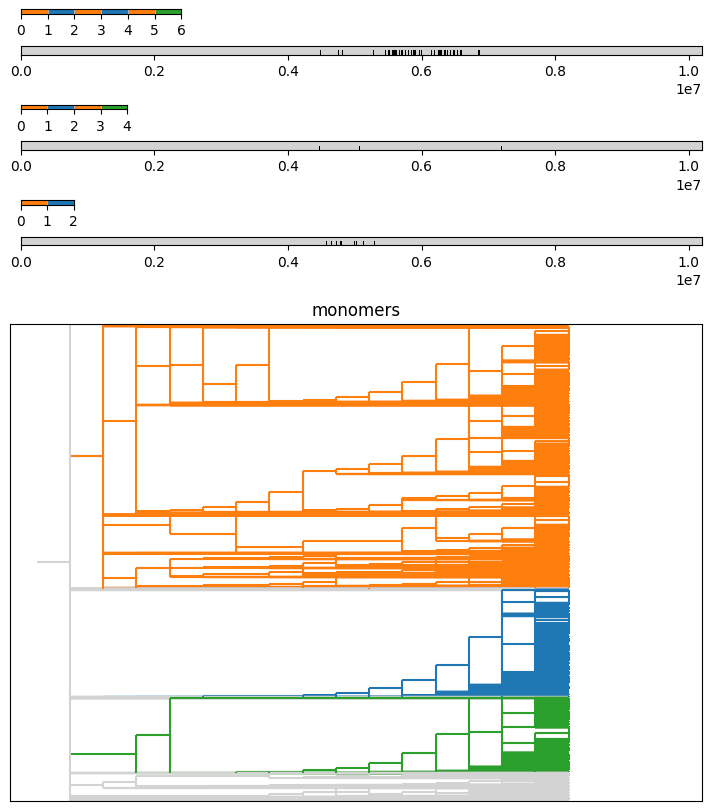

Subtree: [1, 2, 6, 2, 4, 2, 1]


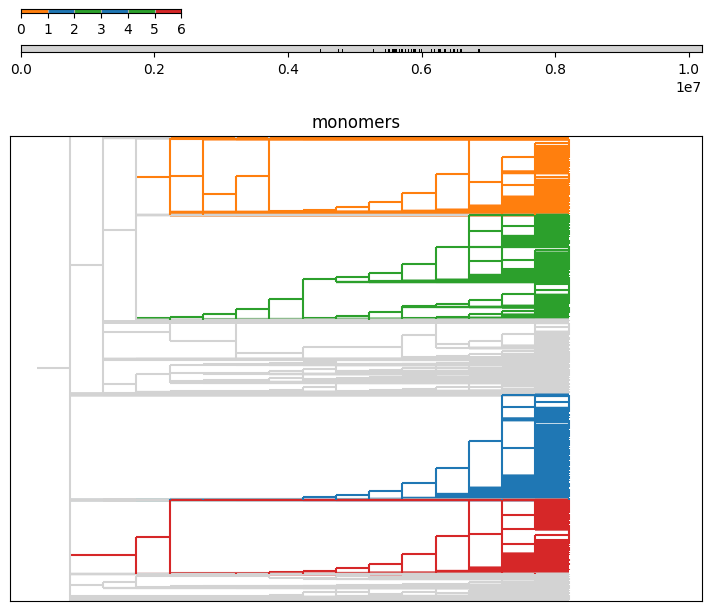

Subtree: [1, 2, 6, 2, 4, 2, 1, 1]


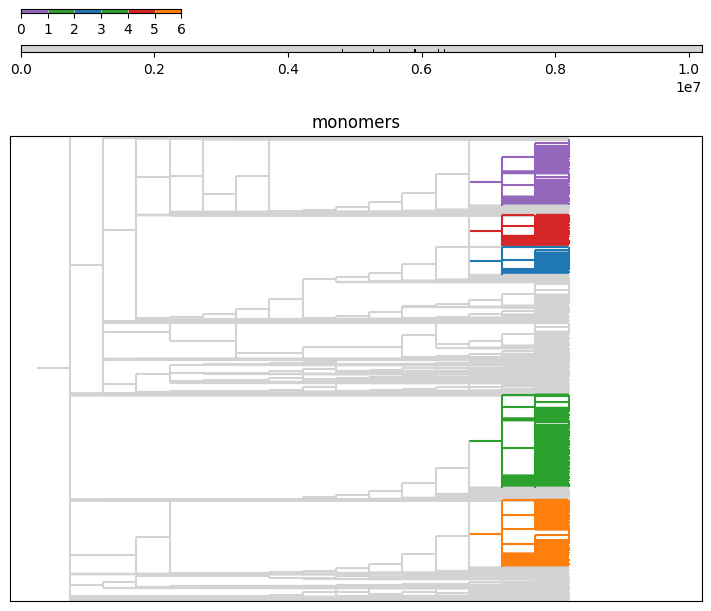

Subtree: [1, 2, 6, 2, 4, 2, 2]


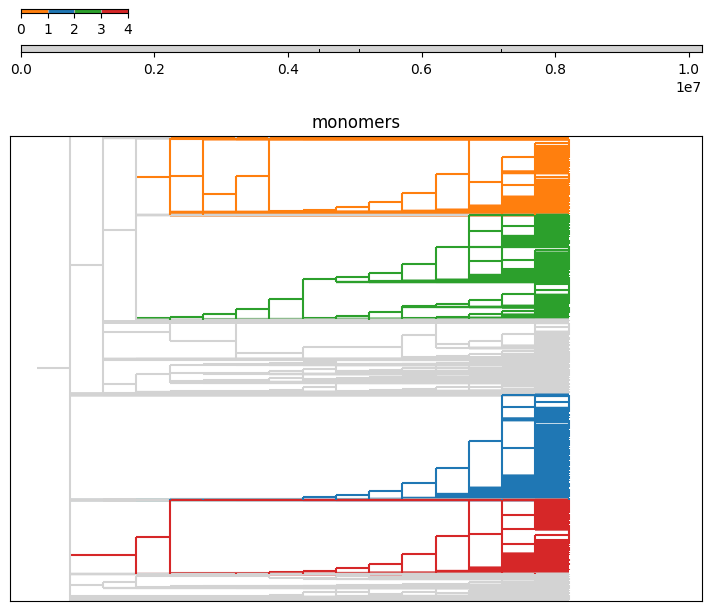

In [21]:
show_hor_tree(hor_tree_root=hor_tree_discrete.as_hor_in_seq, reference_seq=references[reference_seq_id], tree=phylogeny)

In [22]:
phylogenies_equal(hor_tree.as_phyloxml, hor_tree_discrete.as_phyloxml, check_branch_lengths=False)

False